In [1]:
#Download geojson data from the web and save it to a file
import requests
import json
url="https://services.arcgis.com/rYz782eMbySr2srL/arcgis/rest/services/HSR_Bus_Routes/FeatureServer/1/query?outFields=*&where=1%3D1&f=geojson"
response=requests.get(url)
data=response.json()


In [5]:
data_file=open("bus_routes.geojson","w")
json.dump(data,data_file)
data_file.close()

In [7]:
import json

def print_keys(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key))
        if isinstance(value, dict):
            print_keys(value, indent + 1)
        elif isinstance(value, list) and len(value) > 0 and isinstance(value[0], dict):
            print_keys(value[0], indent + 1)

# Asumiendo que 'data' es tu objeto GeoJSON
print_keys(data)

type
features
  type
  id
  geometry
    type
    coordinates
  properties
    OBJECTID
    LINE_NUMBER
    LINE_NAME
    Shape__Length


   OBJECTID LINE_NUMBER LINE_NAME  Shape__Length  \
0         1          01      None   26038.822948   
1         2          02      None   14913.325624   
2         3          03      None   12209.655880   
3         4          04      None   27300.358568   
4         5          05      None   58466.641210   

                                            geometry  
0  MULTILINESTRING ((-79.94831 43.24518, -79.9483...  
1  MULTILINESTRING ((-79.86321 43.26343, -79.8626...  
2  MULTILINESTRING ((-79.87063 43.25311, -79.8694...  
3  MULTILINESTRING ((-79.86538 43.26508, -79.8651...  
4  MULTILINESTRING ((-79.98618 43.25694, -79.9862...  


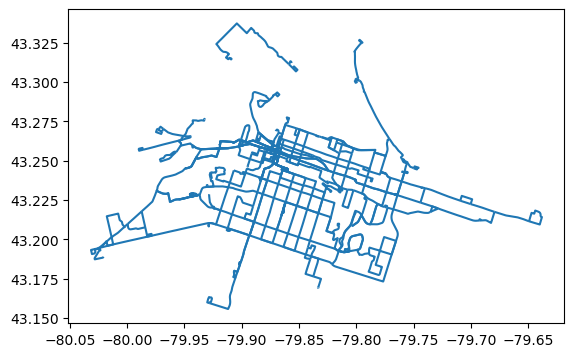

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load GeoJSON Data
data = gpd.read_file("bus_routes.geojson")

# Display the first few rows of the GeoDataFrame
print(data.head())

# Plot the map
data.plot()
plt.show()

In [9]:
import folium
import geopandas as gpd

# Load GeoJSON Data
data = gpd.read_file("bus_routes.geojson")

# Create a map centered around the first feature
m = folium.Map(location=[data.geometry.centroid.y.mean(), data.geometry.centroid.x.mean()], zoom_start=12)

# Add GeoJSON data to the map
folium.GeoJson(data).add_to(m)

# Save the map to an HTML file
m.save("map.html")

# Display the map
m

C:\Users\wmate\AppData\Local\Temp\ipykernel_25888\1362934856.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[data.geometry.centroid.y.mean(), data.geometry.centroid.x.mean()], zoom_start=12)


# NetworkX

Convertir a geojson a grafo

In [17]:
import networkx as nx
import geopandas as gpd
import folium
import pandas as pd

# Load GeoJSON Data
data = gpd.read_file("bus_routes.geojson")
# data = data.to_crs(epsg=26917)  # Proyecta a coordenadas métricas


# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for _, row in data.iterrows():
    if row['geometry'].geom_type == 'MultiLineString':
        for line in row['geometry'].geoms:  # Use .geoms to iterate over LineStrings in MultiLineString
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                G.add_edge(coords[i], coords[i + 1], line_number=row['LINE_NUMBER'])
    elif row['geometry'].geom_type == 'LineString':
        coords = list(row['geometry'].coords)
        for i in range(len(coords) - 1):
            G.add_edge(coords[i], coords[i + 1], line_number=row['LINE_NUMBER'])

# Compute centralities
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

# Find top 10 nodes with highest degree centrality
top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by Degree Centrality:")
for node, centrality in top_degree_nodes:
    print(f"Node: {node}, Centrality: {centrality:.4f}")

# Find top 10 nodes with highest in-degree centrality
top_in_degree_nodes = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by In-Degree Centrality:")
for node, centrality in top_in_degree_nodes:
    print(f"Node: {node}, Centrality: {centrality:.4f}")

# Find top 10 nodes with highest out-degree centrality
top_out_degree_nodes = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by Out-Degree Centrality:")
for node, centrality in top_out_degree_nodes:
    print(f"Node: {node}, Centrality: {centrality:.4f}")

# Create a map centered around the data
m = folium.Map(location=[data.geometry.centroid.y.mean(), data.geometry.centroid.x.mean()], zoom_start=12)

# Add GeoJSON data to the map
folium.GeoJson(data, tooltip=folium.GeoJsonTooltip(fields=['LINE_NUMBER', 'LINE_NAME'])).add_to(m)

# Add markers for top nodes by degree centrality
for node, centrality in top_degree_nodes:
    folium.CircleMarker(
        location=[node[1], node[0]],  # Coordinates are (longitude, latitude) but folium expects (latitude, longitude)
        radius=10,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        tooltip=f"Degree Centrality: {centrality:.4f}"
    ).add_to(m)

# Save the map to an HTML file
m.save("network_analysis_map_v0.html")

# Display the map
m

# Basic network statistics
print("\nNetwork Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.6f}")
print(f"Average clustering coefficient: {nx.average_clustering(G):.6f}")
try:
    print(f"Is the network connected? {nx.is_strongly_connected(G)}")
except:
    print("Could not determine if the network is strongly connected - graph might be too large or have other issues")

Top 10 nodes by Degree Centrality:
Node: (-79.8696540005405, 43.255363999488), Centrality: 0.0006
Node: (-79.8737529994475, 43.2580019990868), Centrality: 0.0006
Node: (-79.8690579995545, 43.2566869989266), Centrality: 0.0006
Node: (-79.8744069997747, 43.2565149991987), Centrality: 0.0005
Node: (-79.8711830000422, 43.2557389987973), Centrality: 0.0005
Node: (-79.8704239999289, 43.2570709994445), Centrality: 0.0005
Node: (-79.8692740005671, 43.2567669988109), Centrality: 0.0005
Node: (-79.8665360001021, 43.2558519992718), Centrality: 0.0005
Node: (-79.9445640002658, 43.2270459988281), Centrality: 0.0005
Node: (-79.8704030005034, 43.2570659989248), Centrality: 0.0005

Top 10 nodes by In-Degree Centrality:
Node: (-79.8711830000422, 43.2557389987973), Centrality: 0.0003
Node: (-79.8704030005034, 43.2570659989248), Centrality: 0.0003
Node: (-79.8705189994582, 43.2570969991185), Centrality: 0.0003
Node: (-79.8737529994475, 43.2580019990868), Centrality: 0.0003
Node: (-79.8692740005671, 43.25

C:\Users\wmate\AppData\Local\Temp\ipykernel_25888\79748920.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[data.geometry.centroid.y.mean(), data.geometry.centroid.x.mean()], zoom_start=12)



Network Statistics:
Number of nodes: 14295
Number of edges: 15642
Network density: 0.000077
Average clustering coefficient: 0.001350
Is the network connected? False


Top 15 nodes by Degree Centrality:
Node: (-79.8696540005405, 43.255363999488), Centrality: 0.0006
Node: (-79.8737529994475, 43.2580019990868), Centrality: 0.0006
Node: (-79.8690579995545, 43.2566869989266), Centrality: 0.0006
Node: (-79.8744069997747, 43.2565149991987), Centrality: 0.0005
Node: (-79.8711830000422, 43.2557389987973), Centrality: 0.0005
Node: (-79.8704239999289, 43.2570709994445), Centrality: 0.0005
Node: (-79.8692740005671, 43.2567669988109), Centrality: 0.0005
Node: (-79.8665360001021, 43.2558519992718), Centrality: 0.0005
Node: (-79.9445640002658, 43.2270459988281), Centrality: 0.0005
Node: (-79.8704030005034, 43.2570659989248), Centrality: 0.0005
Node: (-79.8705189994582, 43.2570969991185), Centrality: 0.0005
Node: (-79.9007470000773, 43.2630159988873), Centrality: 0.0004
Node: (-79.8725189995643, 43.2560579992825), Centrality: 0.0004
Node: (-79.8705530002174, 43.2571059990661), Centrality: 0.0004
Node: (-79.8705059993977, 43.2570929987775), Centrality: 0.0004

Top 1

C:\Users\wmate\AppData\Local\Temp\ipykernel_25888\3900693592.py:61: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[data.geometry.centroid.y.mean(), data.geometry.centroid.x.mean()], zoom_start=12)



Network Statistics:
Number of nodes: 14295
Number of edges: 15642
Network density: 0.000077
Average clustering coefficient: 0.001350
Is the network strongly connected? False
Number of strongly connected components: 10745

Community Detection:
Number of communities detected: 113
Community sizes:
Community
6      224
62     224
76     206
112    198
100    196
35     194
8      194
98     191
21     182
11     180
Name: count, dtype: int64

Route Analysis:
Routes by edge count (most frequent routes in the network):
Route 05: 1277 edges
Route 11: 1176 edges
Route 16: 1094 edges
Route 43: 1083 edges
Route 41: 1012 edges
Route 44: 936 edges
Route 10: 782 edges
Route 04: 694 edges
Route 55: 605 edges
Route 09: 579 edges
Route 56: 526 edges
Route 51: 518 edges
Route 35: 499 edges
Route 34: 442 edges
Route 33: 403 edges
Route 02: 376 edges
Route 52: 373 edges
Route 22: 357 edges
Route 03: 334 edges
Route 20: 294 edges
Route 06: 278 edges
Route 21: 259 edges
Route 27: 258 edges
Route 18: 248 e

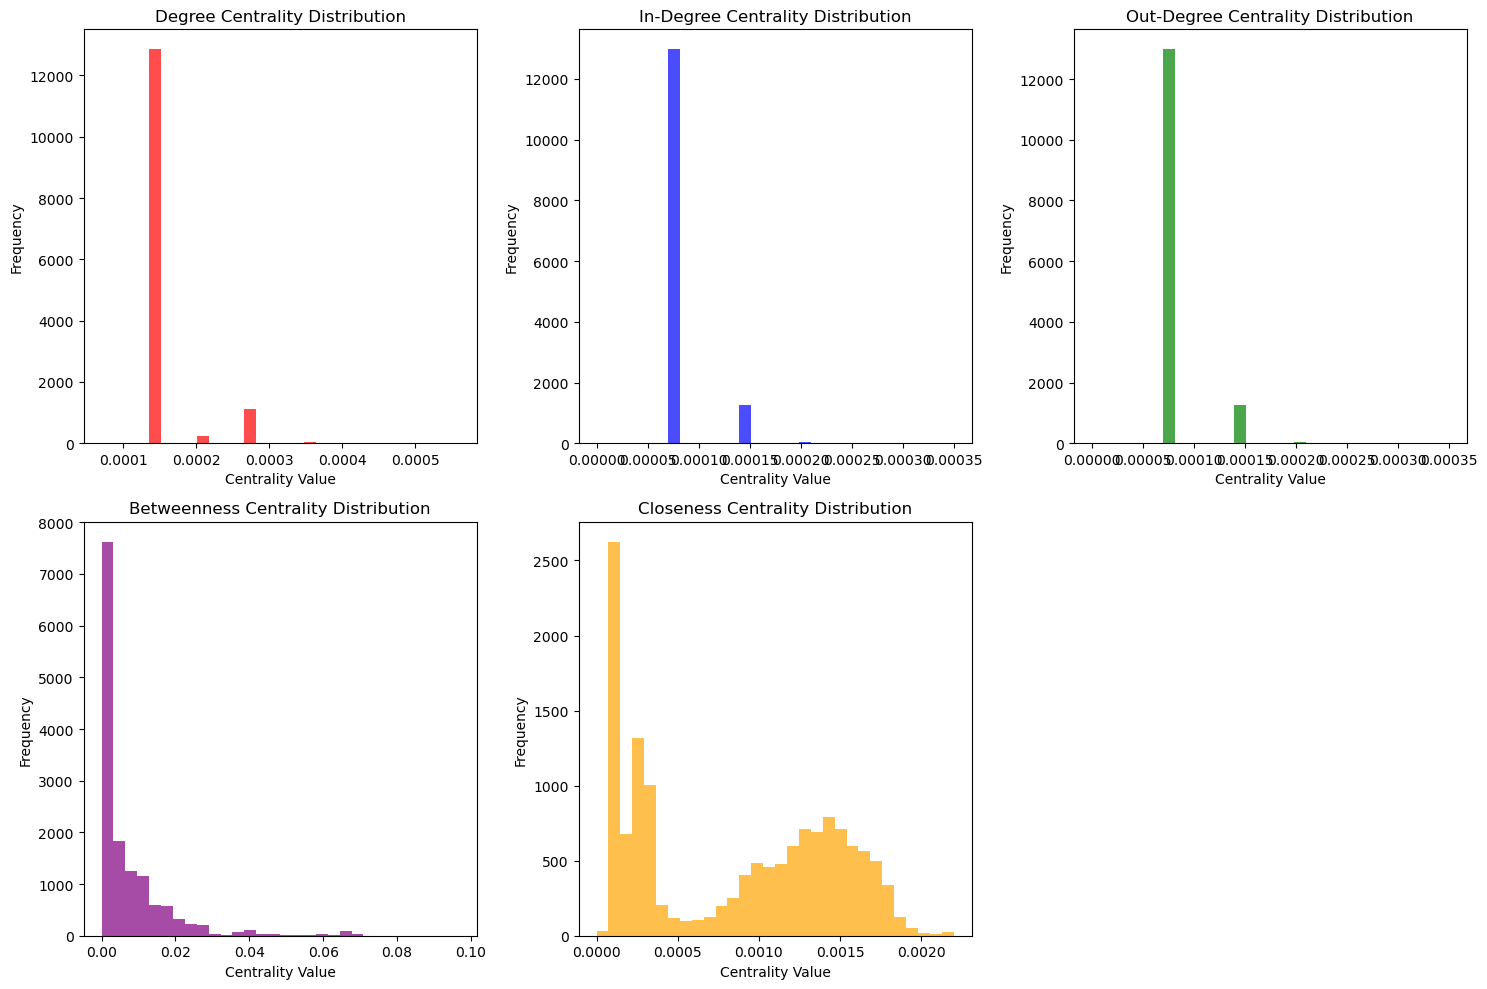

In [ ]:
import networkx as nx
import geopandas as gpd
import folium
import pandas as pd
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster

# Load GeoJSON Data
data = gpd.read_file("bus_routes.geojson")

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for _, row in data.iterrows():
    if row['geometry'].geom_type == 'MultiLineString':
        for line in row['geometry'].geoms:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                G.add_edge(coords[i], coords[i + 1], line_number=row['LINE_NUMBER'])
    elif row['geometry'].geom_type == 'LineString':
        coords = list(row['geometry'].coords)
        for i in range(len(coords) - 1):
            G.add_edge(coords[i], coords[i + 1], line_number=row['LINE_NUMBER'])

# Compute centralities
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, k=100)  # Use k=100 for approximation in large networks
closeness_centrality = nx.closeness_centrality(G)

# Find top nodes with highest centrality measures
top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:15]
top_in_degree_nodes = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:15]
top_out_degree_nodes = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:15]
top_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:15]
top_closeness_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:15]

print("Top 15 nodes by Degree Centrality:")
for node, centrality in top_degree_nodes:
    print(f"Node: {node}, Centrality: {centrality:.4f}")

print("\nTop 15 nodes by In-Degree Centrality:")
for node, centrality in top_in_degree_nodes:
    print(f"Node: {node}, Centrality: {centrality:.4f}")

print("\nTop 15 nodes by Out-Degree Centrality:")
for node, centrality in top_out_degree_nodes:
    print(f"Node: {node}, Centrality: {centrality:.4f}")

print("\nTop 15 nodes by Betweenness Centrality:")
for node, centrality in top_betweenness_nodes:
    print(f"Node: {node}, Centrality: {centrality:.4f}")

print("\nTop 15 nodes by Closeness Centrality:")
for node, centrality in top_closeness_nodes:
    print(f"Node: {node}, Centrality: {centrality:.4f}")

# Create a map centered around the data
m = folium.Map(location=[data.geometry.centroid.y.mean(), data.geometry.centroid.x.mean()], zoom_start=12)

# Add GeoJSON data to the map
folium.GeoJson(data, tooltip=folium.GeoJsonTooltip(fields=['LINE_NUMBER', 'LINE_NAME'])).add_to(m)

# Create feature groups for each type of centrality
degree_group = folium.FeatureGroup(name='Degree Centrality')
in_degree_group = folium.FeatureGroup(name='In-Degree Centrality')
out_degree_group = folium.FeatureGroup(name='Out-Degree Centrality')
betweenness_group = folium.FeatureGroup(name='Betweenness Centrality')
closeness_group = folium.FeatureGroup(name='Closeness Centrality')

# Add markers for top nodes by degree centrality (Red)
for node, centrality in top_degree_nodes:
    folium.CircleMarker(
        location=[node[1], node[0]],
        radius=10,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        tooltip=f"Degree Centrality: {centrality:.4f}"
    ).add_to(degree_group)

# Add markers for top nodes by in-degree centrality (Blue)
for node, centrality in top_in_degree_nodes:
    folium.CircleMarker(
        location=[node[1], node[0]],
        radius=10,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        tooltip=f"In-Degree Centrality: {centrality:.4f}"
    ).add_to(in_degree_group)

# Add markers for top nodes by out-degree centrality (Green)
for node, centrality in top_out_degree_nodes:
    folium.CircleMarker(
        location=[node[1], node[0]],
        radius=10,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        tooltip=f"Out-Degree Centrality: {centrality:.4f}"
    ).add_to(out_degree_group)

# Add markers for top nodes by betweenness centrality (Purple)
for node, centrality in top_betweenness_nodes:
    folium.CircleMarker(
        location=[node[1], node[0]],
        radius=10,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        tooltip=f"Betweenness Centrality: {centrality:.4f}"
    ).add_to(betweenness_group)

# Add markers for top nodes by closeness centrality (Orange)
for node, centrality in top_closeness_nodes:
    folium.CircleMarker(
        location=[node[1], node[0]],
        radius=10,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7,
        tooltip=f"Closeness Centrality: {centrality:.4f}"
    ).add_to(closeness_group)

# Add all feature groups to the map
degree_group.add_to(m)
in_degree_group.add_to(m)
out_degree_group.add_to(m)
betweenness_group.add_to(m)
closeness_group.add_to(m)

# Add layer control to toggle between different centrality measures
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save("network_analysis_map.html")

# Display the map
m

# Network Statistics
print("\nNetwork Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.6f}")
try:
    print(f"Average clustering coefficient: {nx.average_clustering(G):.6f}")
except:
    print("Could not compute average clustering coefficient - might take too long for large networks")
try:
    print(f"Is the network strongly connected? {nx.is_strongly_connected(G)}")
    if not nx.is_strongly_connected(G):
        print(f"Number of strongly connected components: {len(list(nx.strongly_connected_components(G)))}")
except:
    print("Could not determine if the network is strongly connected - graph might be too large")

# Community detection using the Girvan-Newman algorithm (may take long time for large networks)
try:
    print("\nCommunity Detection:")
    import community
    G_undirected = G.to_undirected()
    partition = community.best_partition(G_undirected)
    print(f"Number of communities detected: {len(set(partition.values()))}")
    
    # Create a DataFrame to store node communities
    communities_df = pd.DataFrame(list(partition.items()), columns=['Node', 'Community'])
    print(f"Community sizes:")
    print(communities_df['Community'].value_counts().head(10))
except:
    print("Could not perform community detection - install 'python-louvain' package or graph might be too large")

# Analyzing route frequencies
print("\nRoute Analysis:")
route_counts = {}
for u, v, data in G.edges(data=True):
    if 'line_number' in data:
        line = data['line_number']
        if line in route_counts:
            route_counts[line] += 1
        else:
            route_counts[line] = 1

# Sort routes by frequency
sorted_routes = sorted(route_counts.items(), key=lambda x: x[1], reverse=True)
print("Routes by edge count (most frequent routes in the network):")
for route, count in sorted_routes:
    print(f"Route {route}: {count} edges")

# Create histograms of centrality measures
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(list(degree_centrality.values()), bins=30, color='red', alpha=0.7)
plt.title('Degree Centrality Distribution')
plt.xlabel('Centrality Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(list(in_degree_centrality.values()), bins=30, color='blue', alpha=0.7)
plt.title('In-Degree Centrality Distribution')
plt.xlabel('Centrality Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.hist(list(out_degree_centrality.values()), bins=30, color='green', alpha=0.7)
plt.title('Out-Degree Centrality Distribution')
plt.xlabel('Centrality Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
plt.hist(list(betweenness_centrality.values()), bins=30, color='purple', alpha=0.7)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Centrality Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(list(closeness_centrality.values()), bins=30, color='orange', alpha=0.7)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Centrality Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('centrality_distributions.png')
plt.show()

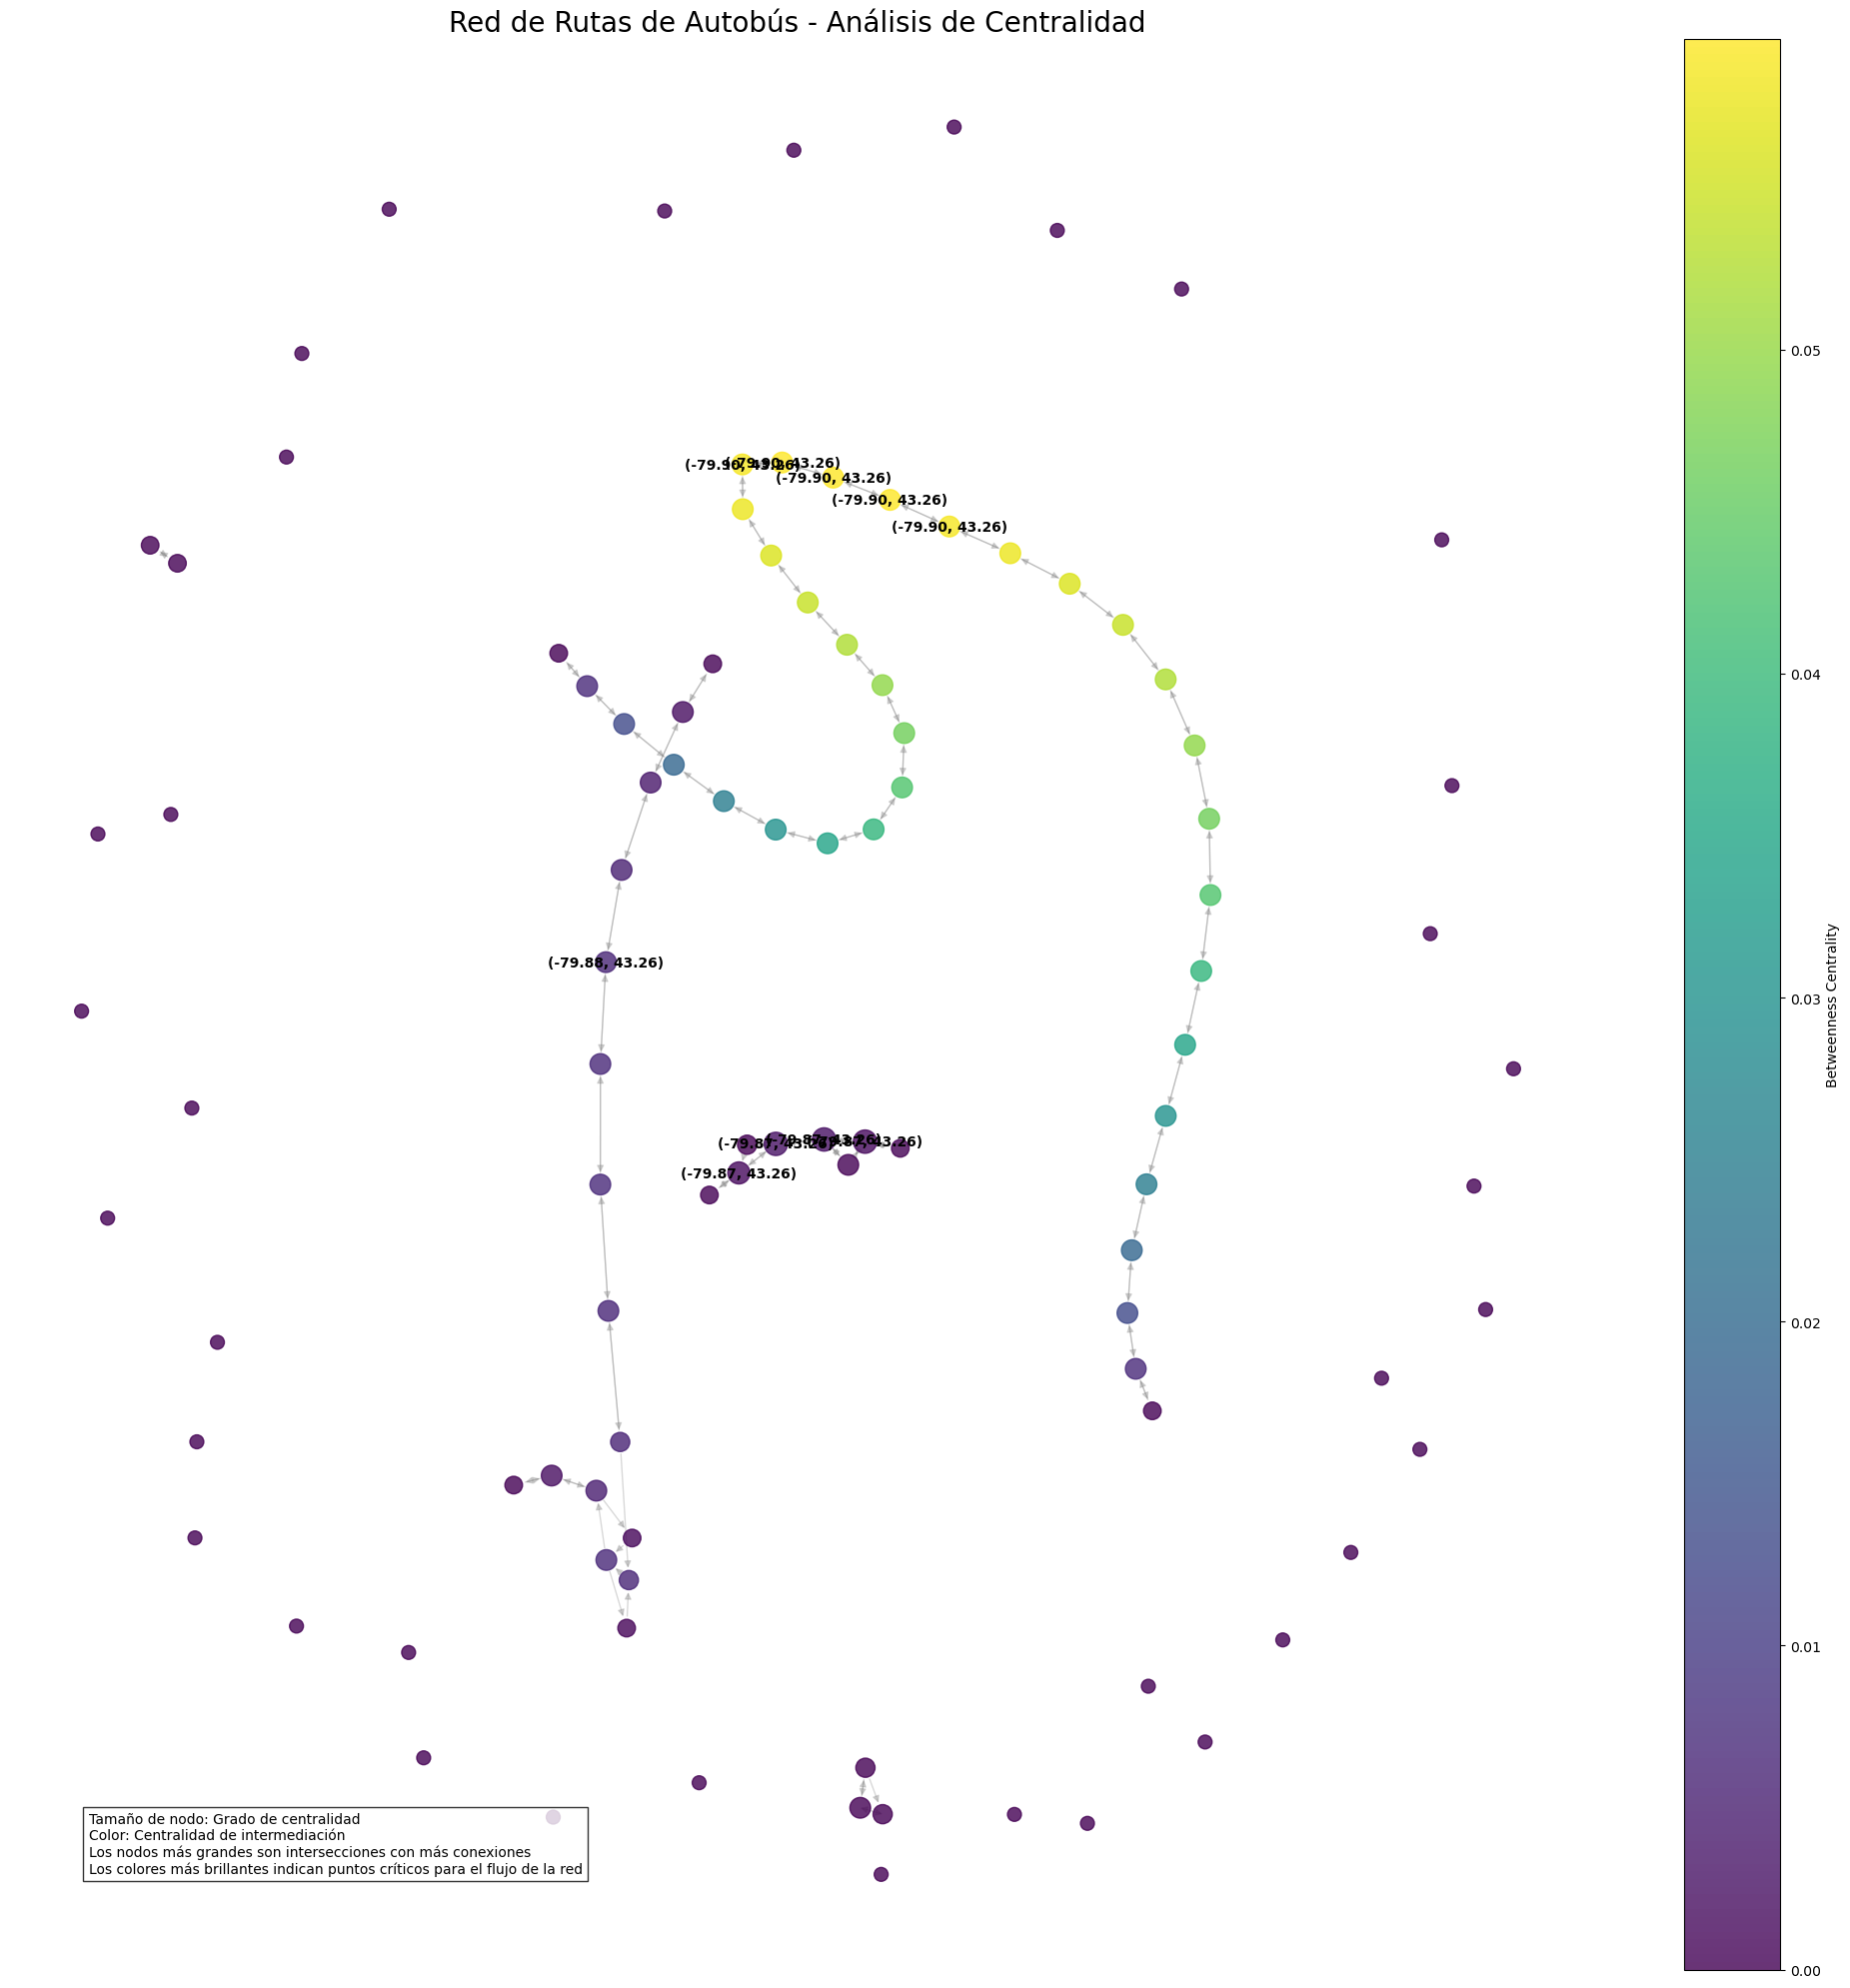

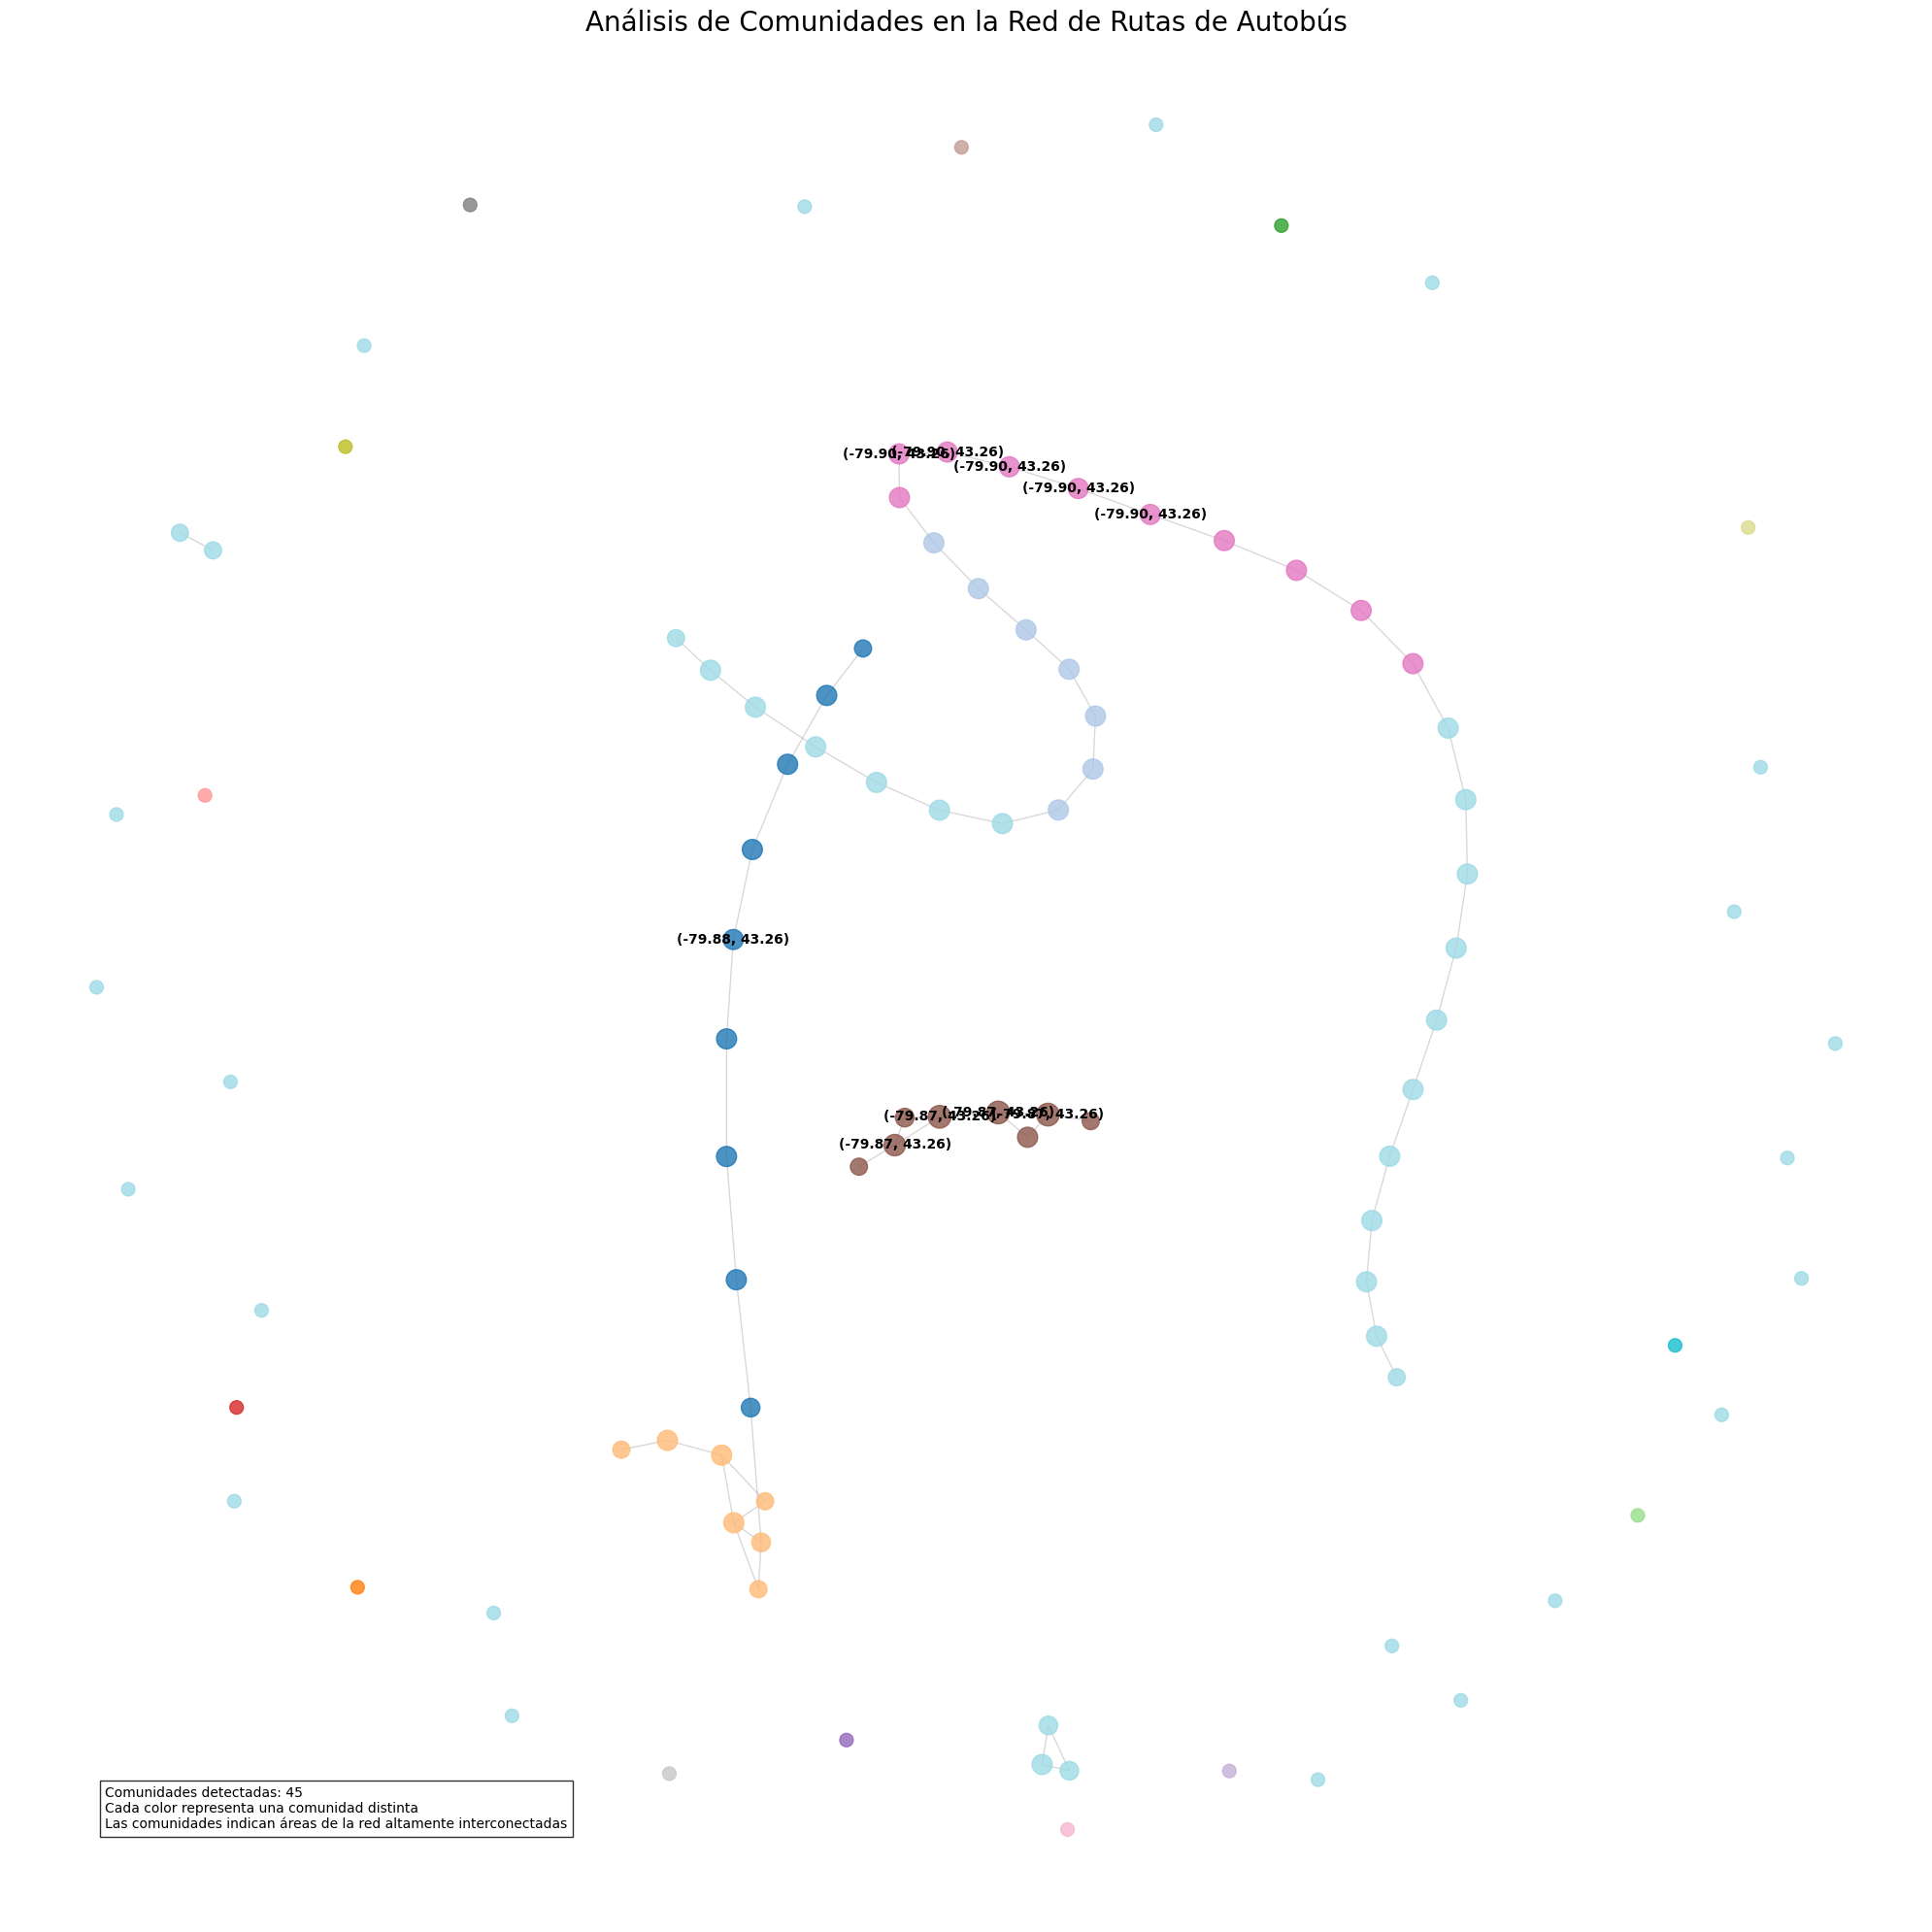

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Crear un subgrafo más pequeño para visualización
# (El grafo completo podría ser demasiado grande para visualizar claramente)
def create_subgraph_for_visualization(G, max_nodes=150):
    # Usando los nodos con mayor centralidad
    top_nodes = [node for node, _ in sorted(nx.degree_centrality(G).items(), 
                                          key=lambda x: x[1], 
                                          reverse=True)[:max_nodes]]
    
    # Crear subgrafo con estos nodos
    subgraph = G.subgraph(top_nodes)
    return subgraph

# Crear un subgrafo manejable para visualización
sub_G = create_subgraph_for_visualization(G, max_nodes=100)

# Calcular centralidades para el subgrafo
degree_cent = nx.degree_centrality(sub_G)
betweenness_cent = nx.betweenness_centrality(sub_G)

# Preparar posiciones de nodos usando un layout que funcione bien para redes de transporte
pos = nx.spring_layout(sub_G, seed=42)  # spring_layout es bueno para mostrar la estructura de la red

# Crear figura grande para mejor visualización
plt.figure(figsize=(20, 20))

# Dibujar el grafo con nodos coloreados según centralidad
# El tamaño de los nodos representa el grado de centralidad
node_sizes = [v * 3000 + 100 for v in degree_cent.values()]
node_colors = [betweenness_cent[node] for node in sub_G.nodes()]

# Dibujar aristas
nx.draw_networkx_edges(sub_G, pos, alpha=0.3, edge_color="gray")

# Dibujar nodos
nodes = nx.draw_networkx_nodes(sub_G, pos, 
                              node_size=node_sizes,
                              node_color=node_colors, 
                              cmap=plt.cm.viridis,
                              alpha=0.8)

# Añadir barra de color para la centralidad de intermediación
plt.colorbar(nodes, label="Betweenness Centrality")

# Identificar los 5 nodos con mayor centralidad
top_degree_nodes = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness_nodes = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:5]

# Etiquetar solo los nodos más importantes para no sobrecargar la visualización
node_labels = {}
for node, centrality in set(top_degree_nodes + top_betweenness_nodes):
    # Abreviar las coordenadas para las etiquetas
    coords = node
    node_labels[node] = f"({coords[0]:.2f}, {coords[1]:.2f})"

nx.draw_networkx_labels(sub_G, pos, labels=node_labels, font_size=10, font_weight="bold")

# Añadir título y leyenda explicativa
plt.title("Red de Rutas de Autobús - Análisis de Centralidad", fontsize=20)
plt.text(0.05, 0.05, 
         "Tamaño de nodo: Grado de centralidad\n"
         "Color: Centralidad de intermediación\n"
         "Los nodos más grandes son intersecciones con más conexiones\n"
         "Los colores más brillantes indican puntos críticos para el flujo de la red", 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

# Ajustes finales de la visualización
plt.axis("off")  # Ocultar ejes
plt.tight_layout()

# Guardar gráfico en alta resolución
plt.savefig('network_graph_visualization.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

# Crear una segunda visualización enfocada en las comunidades
try:
    import community
    G_undirected = sub_G.to_undirected()
    partition = community.best_partition(G_undirected)
    
    plt.figure(figsize=(20, 20))
    
    # Colores por comunidad
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in partition.values()]
    
    # Dibujar la red con colores por comunidad
    nx.draw_networkx_edges(G_undirected, pos, alpha=0.3, edge_color="gray")
    nx.draw_networkx_nodes(G_undirected, pos, 
                          node_size=node_sizes,
                          node_color=colors, 
                          alpha=0.8)
    
    nx.draw_networkx_labels(G_undirected, pos, labels=node_labels, font_size=10, font_weight="bold")
    
    plt.title("Análisis de Comunidades en la Red de Rutas de Autobús", fontsize=20)
    plt.text(0.05, 0.05, 
             f"Comunidades detectadas: {len(set(partition.values()))}\n"
             "Cada color representa una comunidad distinta\n"
             "Las comunidades indican áreas de la red altamente interconectadas", 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.axis("off")
    plt.tight_layout()
    plt.savefig('network_communities_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
except:
    print("No se pudo crear la visualización de comunidades.")

CENTRALIDAD DE GRADO (conexiones directas):
Terminal Central: 0.43
Plaza Mayor: 0.43
Centro Comercial: 0.43
Hospital: 0.29
Universidad: 0.29
Estadio: 0.29
Aeropuerto: 0.29
Barrio Norte: 0.14

CENTRALIDAD DE INTERMEDIACIÓN (importancia como punto de paso):
Plaza Mayor: 0.57
Terminal Central: 0.48
Centro Comercial: 0.48
Aeropuerto: 0.29
Hospital: 0.00
Universidad: 0.00
Estadio: 0.00
Barrio Norte: 0.00


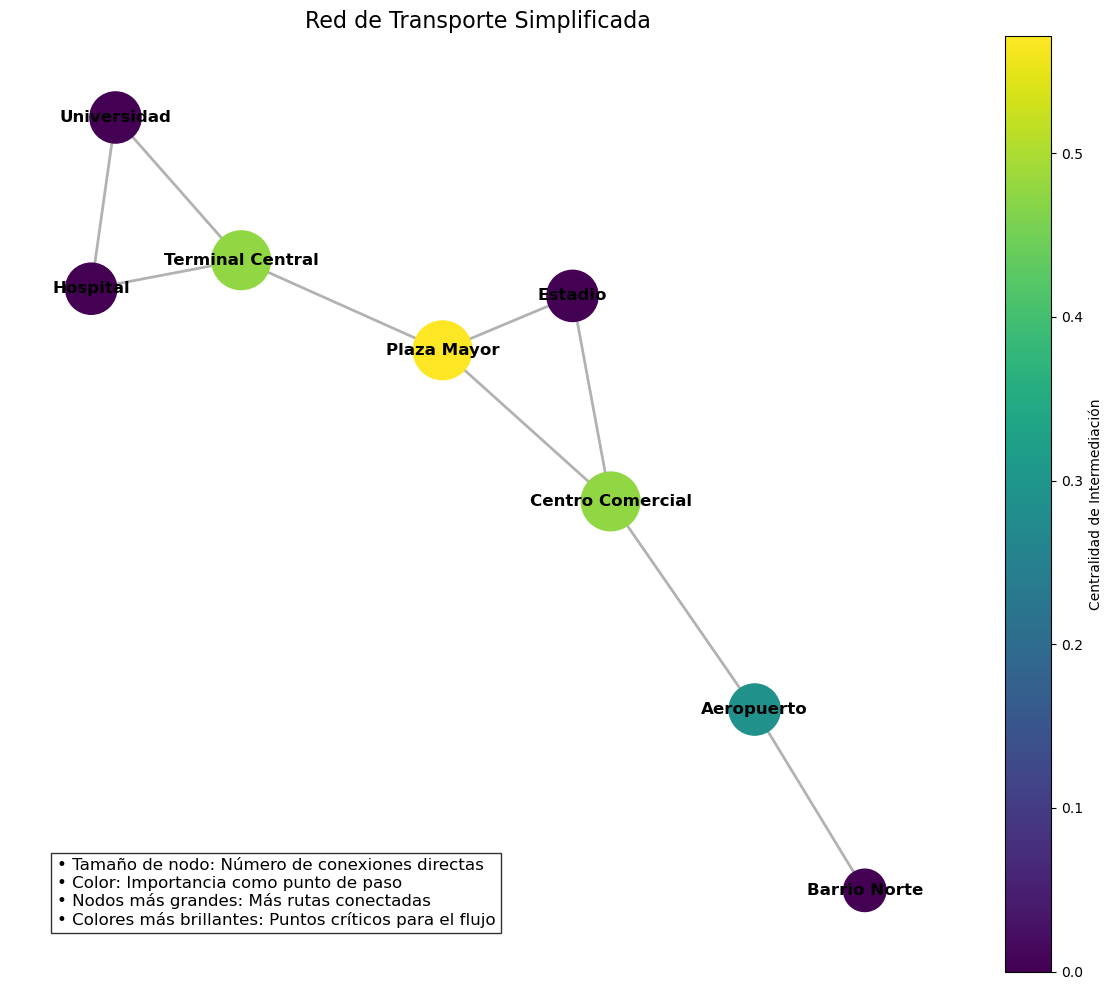

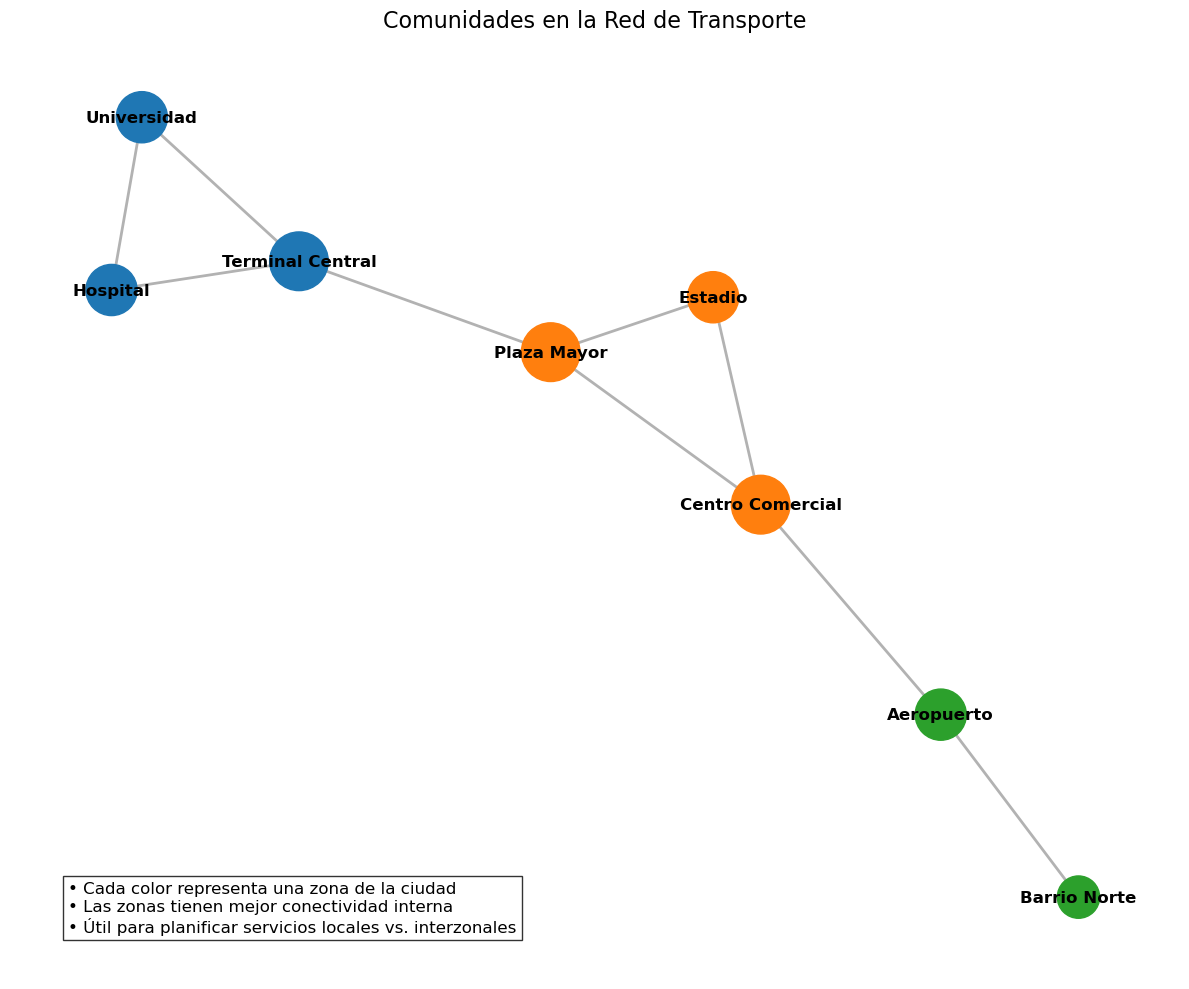

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear una red simple de transporte
G = nx.Graph()

# Añadir nodos (estaciones de autobús)
estaciones = ["Terminal Central", "Plaza Mayor", "Hospital", "Universidad", 
              "Centro Comercial", "Estadio", "Aeropuerto", "Barrio Norte"]
G.add_nodes_from(estaciones)

# Añadir enlaces (rutas entre estaciones)
rutas = [("Terminal Central", "Plaza Mayor"), 
         ("Terminal Central", "Hospital"),
         ("Terminal Central", "Universidad"),
         ("Plaza Mayor", "Centro Comercial"),
         ("Plaza Mayor", "Estadio"),
         ("Hospital", "Universidad"),
         ("Centro Comercial", "Estadio"),
         ("Centro Comercial", "Aeropuerto"),
         ("Aeropuerto", "Barrio Norte")]
G.add_edges_from(rutas)

# Calcular centralidades
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)
closeness_cent = nx.closeness_centrality(G)

# Imprimir resultados
print("CENTRALIDAD DE GRADO (conexiones directas):")
for estacion, valor in sorted(degree_cent.items(), key=lambda x: x[1], reverse=True):
    print(f"{estacion}: {valor:.2f}")

print("\nCENTRALIDAD DE INTERMEDIACIÓN (importancia como punto de paso):")
for estacion, valor in sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True):
    print(f"{estacion}: {valor:.2f}")

# Visualizar la red
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)

# Tamaño según centralidad de grado
node_sizes = [degree_cent[node] * 3000 + 500 for node in G.nodes()]
# Color según centralidad de intermediación
node_colors = [betweenness_cent[node] for node in G.nodes()]

# Dibujar nodos y enlaces
nx.draw_networkx_edges(G, pos, alpha=0.3, width=2)
nodes = nx.draw_networkx_nodes(G, pos, 
                               node_size=node_sizes,
                               node_color=node_colors,
                               cmap=plt.cm.viridis)

# Añadir etiquetas
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

plt.colorbar(nodes, label="Centralidad de Intermediación")
plt.title("Red de Transporte Simplificada", fontsize=16)
plt.text(0.05, 0.05, 
         "• Tamaño de nodo: Número de conexiones directas\n"
         "• Color: Importancia como punto de paso\n"
         "• Nodos más grandes: Más rutas conectadas\n"
         "• Colores más brillantes: Puntos críticos para el flujo", 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=12)

plt.axis("off")
plt.tight_layout()
plt.show()

# Detectar comunidades
try:
    import community
    partition = community.best_partition(G)
    
    # Visualizar comunidades
    plt.figure(figsize=(12, 10))
    
    # Color por comunidad
    cmap = plt.get_cmap('tab10')
    colors = [cmap(partition[node]) for node in G.nodes()]
    
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=2)
    nx.draw_networkx_nodes(G, pos, 
                           node_size=node_sizes,
                           node_color=colors)
    
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
    
    plt.title("Comunidades en la Red de Transporte", fontsize=16)
    plt.text(0.05, 0.05, 
             "• Cada color representa una zona de la ciudad\n"
             "• Las zonas tienen mejor conectividad interna\n"
             "• Útil para planificar servicios locales vs. interzonales", 
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=12)
    
    plt.axis("off")
    plt.tight_layout()
    plt.show()
except:
    print("No se pudo crear la visualización de comunidades.")

Cargando datos de rutas de autobús...
Número de rutas cargadas: 34

Primeras líneas de datos:
   OBJECTID LINE_NUMBER LINE_NAME  Shape__Length  \
0         1          01      None   26038.822948   
1         2          02      None   14913.325624   
2         3          03      None   12209.655880   
3         4          04      None   27300.358568   
4         5          05      None   58466.641210   

                                            geometry  
0  MULTILINESTRING ((-79.94831 43.24518, -79.9483...  
1  MULTILINESTRING ((-79.86321 43.26343, -79.8626...  
2  MULTILINESTRING ((-79.87063 43.25311, -79.8694...  
3  MULTILINESTRING ((-79.86538 43.26508, -79.8651...  
4  MULTILINESTRING ((-79.98618 43.25694, -79.9862...  

Columnas disponibles:
['OBJECTID', 'LINE_NUMBER', 'LINE_NAME', 'Shape__Length', 'geometry']

Creando red de transporte a partir de las rutas...
Red creada con 14295 nodos y 15642 segmentos de ruta.

Estadísticas básicas de la red:
Número de nodos (intersecciones

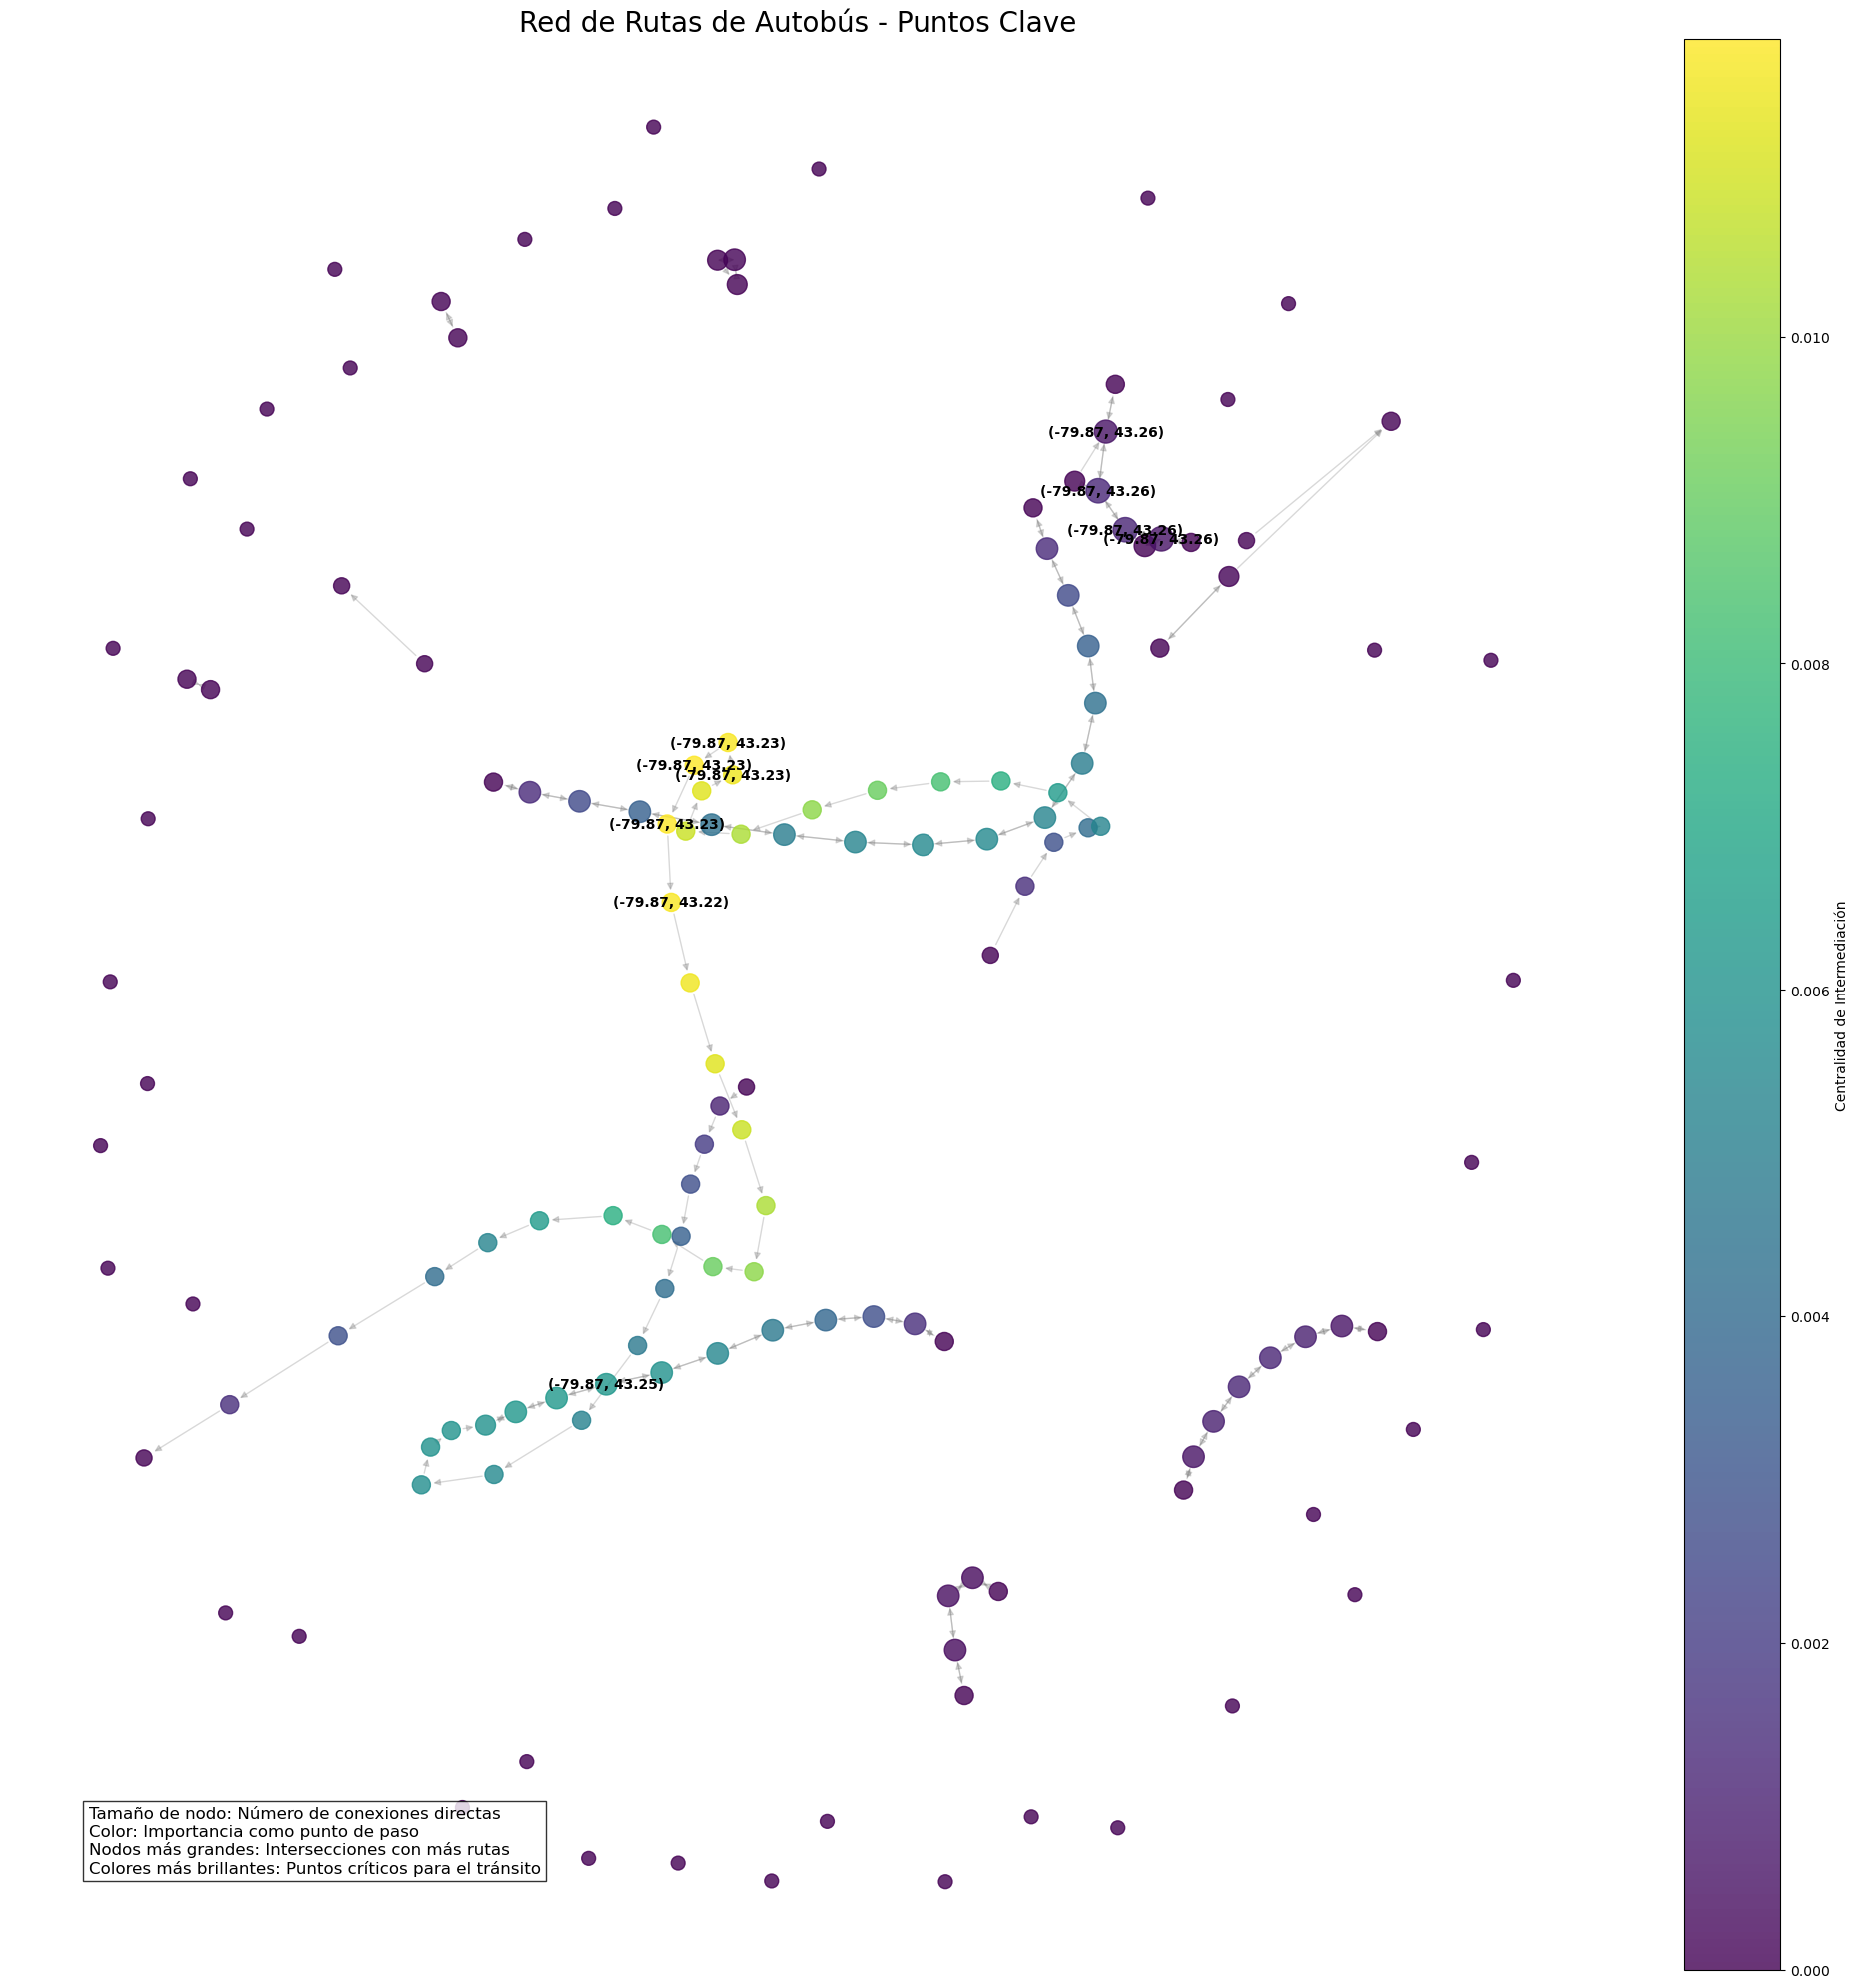


Identificando comunidades en la red de transporte...
Se han identificado 54 comunidades principales

Tamaño de cada comunidad:
Comunidad 17: 13 nodos
Comunidad 22: 12 nodos
Comunidad 5: 11 nodos
Comunidad 35: 10 nodos
Comunidad 37: 9 nodos
Comunidad 32: 9 nodos
Comunidad 10: 8 nodos
Comunidad 14: 8 nodos
Comunidad 26: 7 nodos
Comunidad 16: 5 nodos
Comunidad 21: 4 nodos
Comunidad 28: 3 nodos
Comunidad 4: 2 nodos
Comunidad 36: 2 nodos
Comunidad 53: 2 nodos
Comunidad 2: 1 nodos
Comunidad 6: 1 nodos
Comunidad 8: 1 nodos
Comunidad 9: 1 nodos
Comunidad 11: 1 nodos
Comunidad 12: 1 nodos
Comunidad 13: 1 nodos
Comunidad 15: 1 nodos
Comunidad 18: 1 nodos
Comunidad 20: 1 nodos
Comunidad 23: 1 nodos
Comunidad 24: 1 nodos
Comunidad 25: 1 nodos
Comunidad 27: 1 nodos
Comunidad 29: 1 nodos
Comunidad 30: 1 nodos
Comunidad 31: 1 nodos
Comunidad 33: 1 nodos
Comunidad 38: 1 nodos
Comunidad 39: 1 nodos
Comunidad 40: 1 nodos
Comunidad 42: 1 nodos
Comunidad 43: 1 nodos
Comunidad 44: 1 nodos
Comunidad 45: 1 

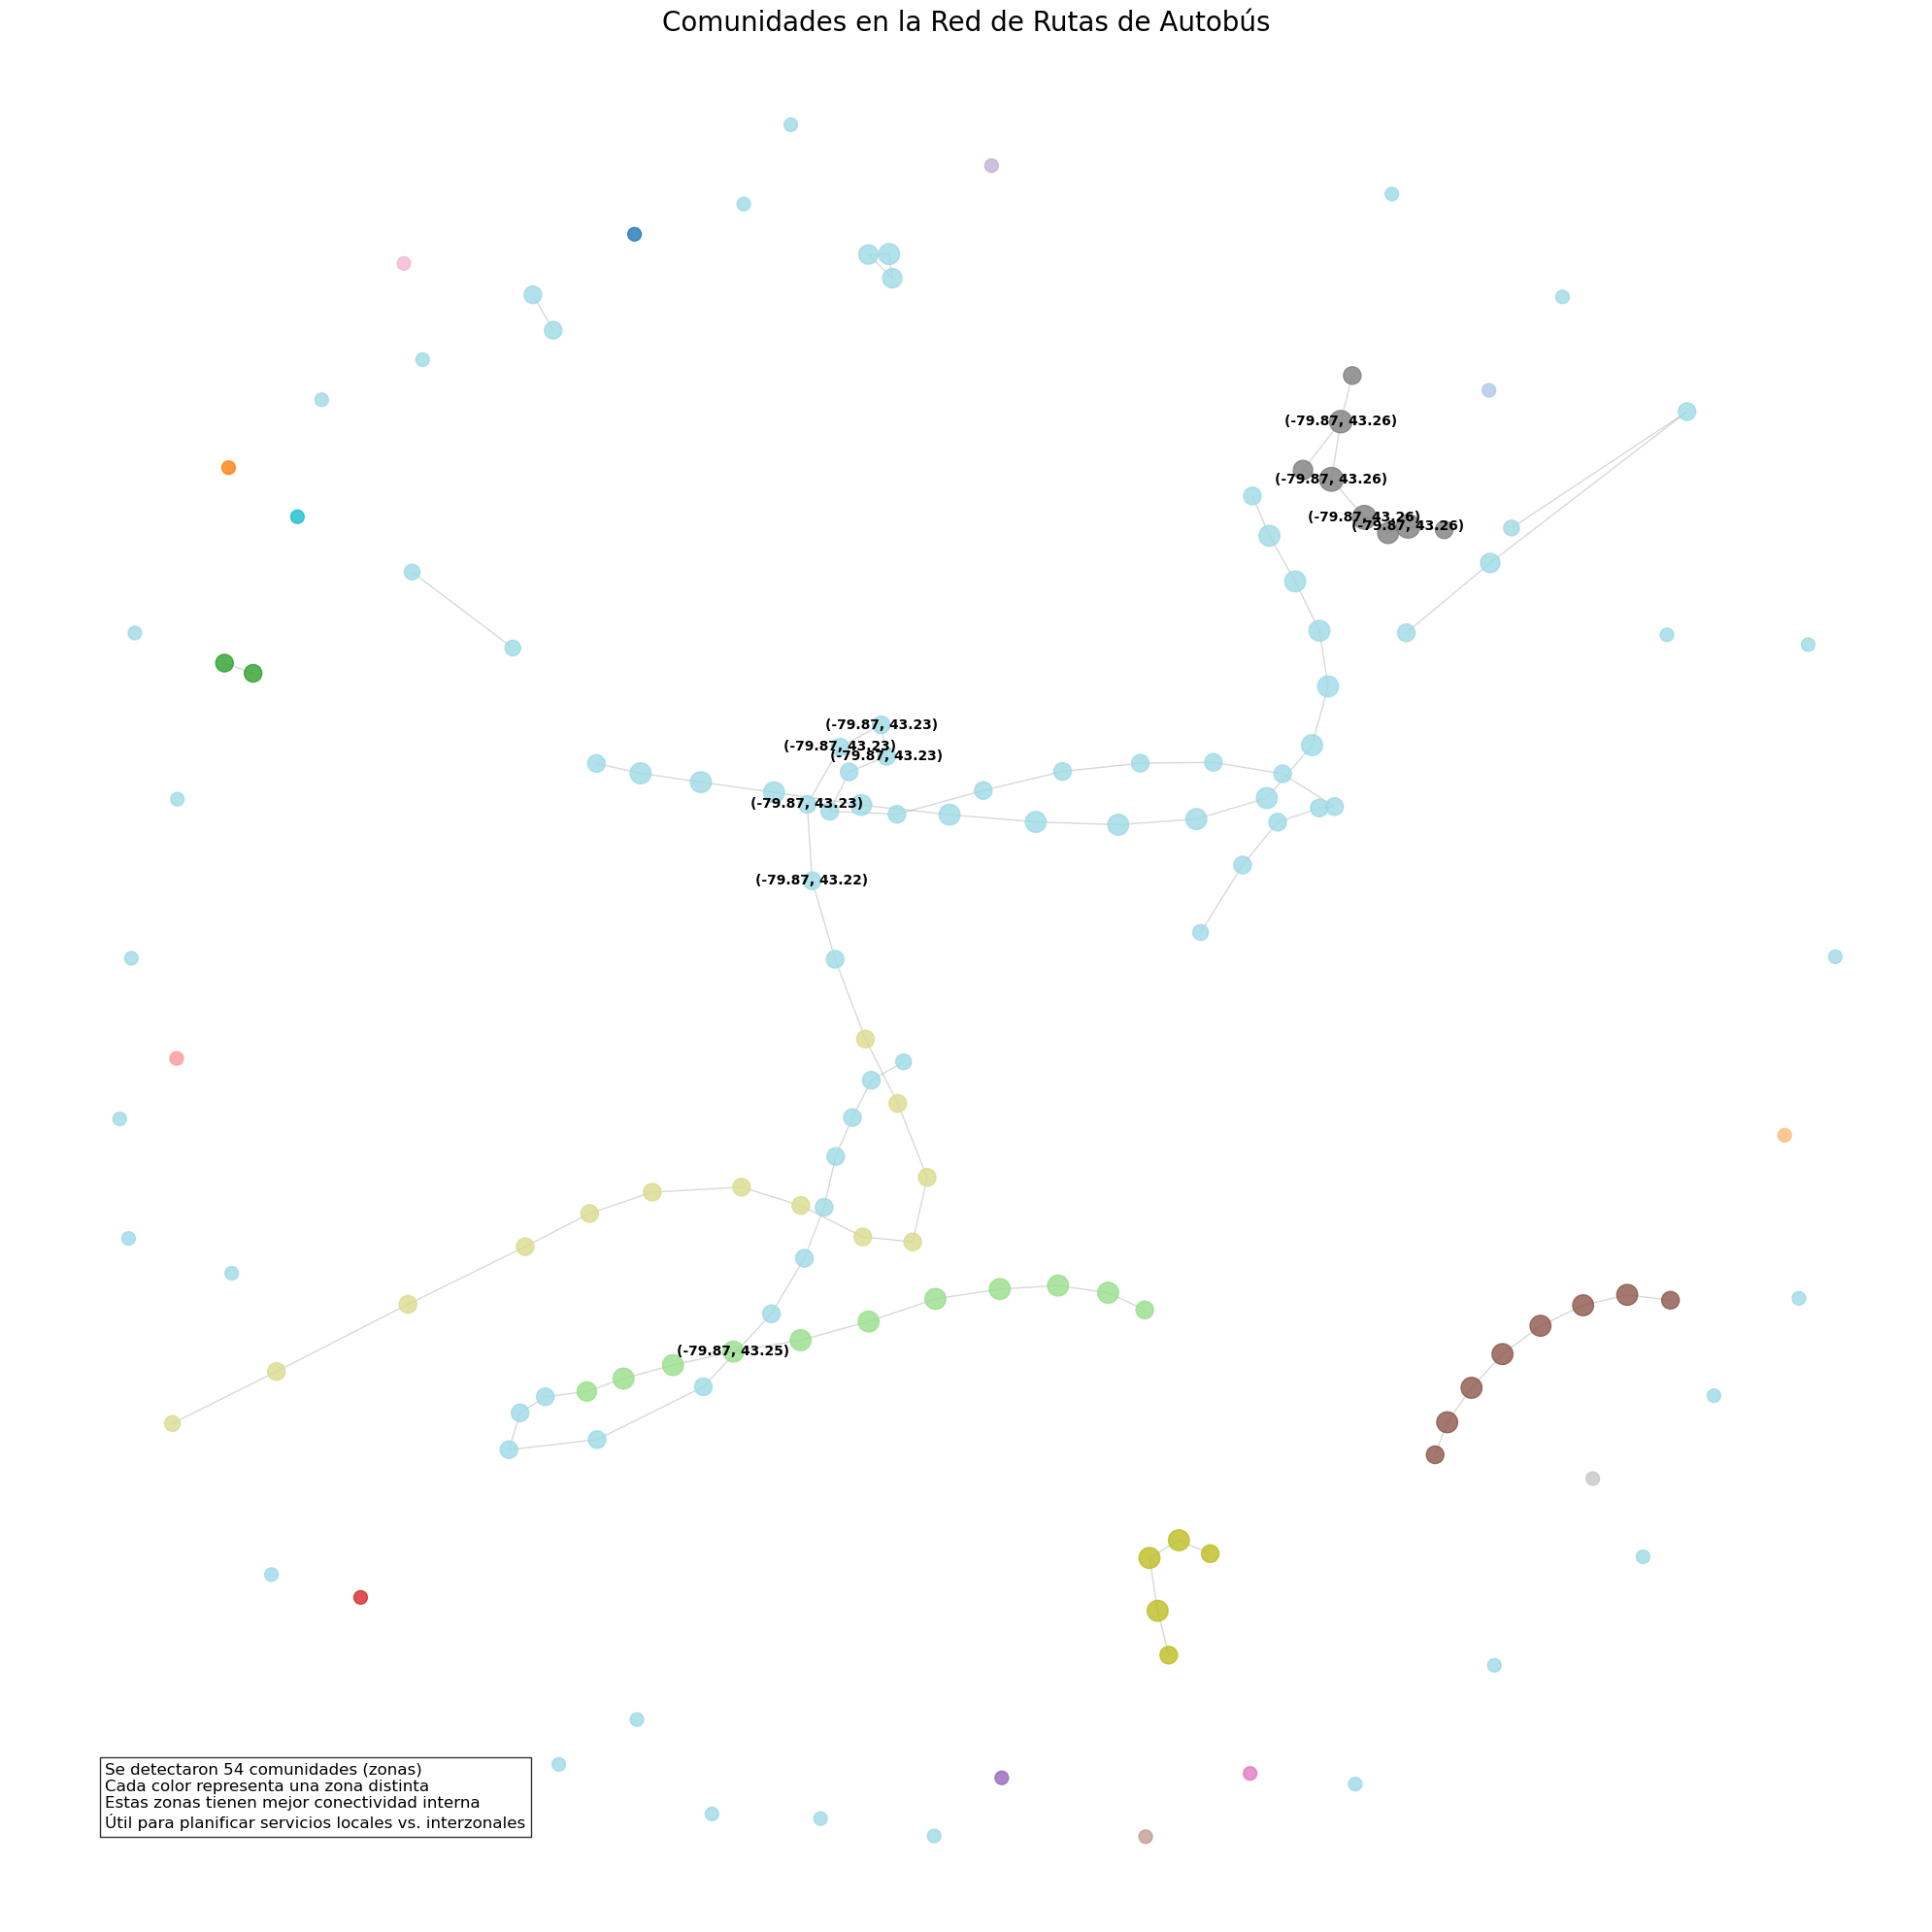


Creando mapa interactivo con los puntos clave...

Análisis completado. Se han generado archivos:
network_analysis_bus_routes.png - Gráfico de la red
network_communities_bus_routes.png - Análisis de comunidades
bus_network_analysis_map.html - Mapa interactivo con puntos clave

Conclusiones del análisis:
Los puntos con mayor centralidad de grado son intersecciones donde convergen múltiples rutas
Los puntos con mayor intermediación son críticos para mantener la conectividad de la red
Las comunidades detectadas representan zonas con buena conectividad interna
Cargando datos de rutas de autobús...
Número de rutas cargadas: 34

Primeras líneas de datos:
   OBJECTID LINE_NUMBER LINE_NAME  Shape__Length  \
0         1          01      None   26038.822948   
1         2          02      None   14913.325624   
2         3          03      None   12209.655880   
3         4          04      None   27300.358568   
4         5          05      None   58466.641210   

                              

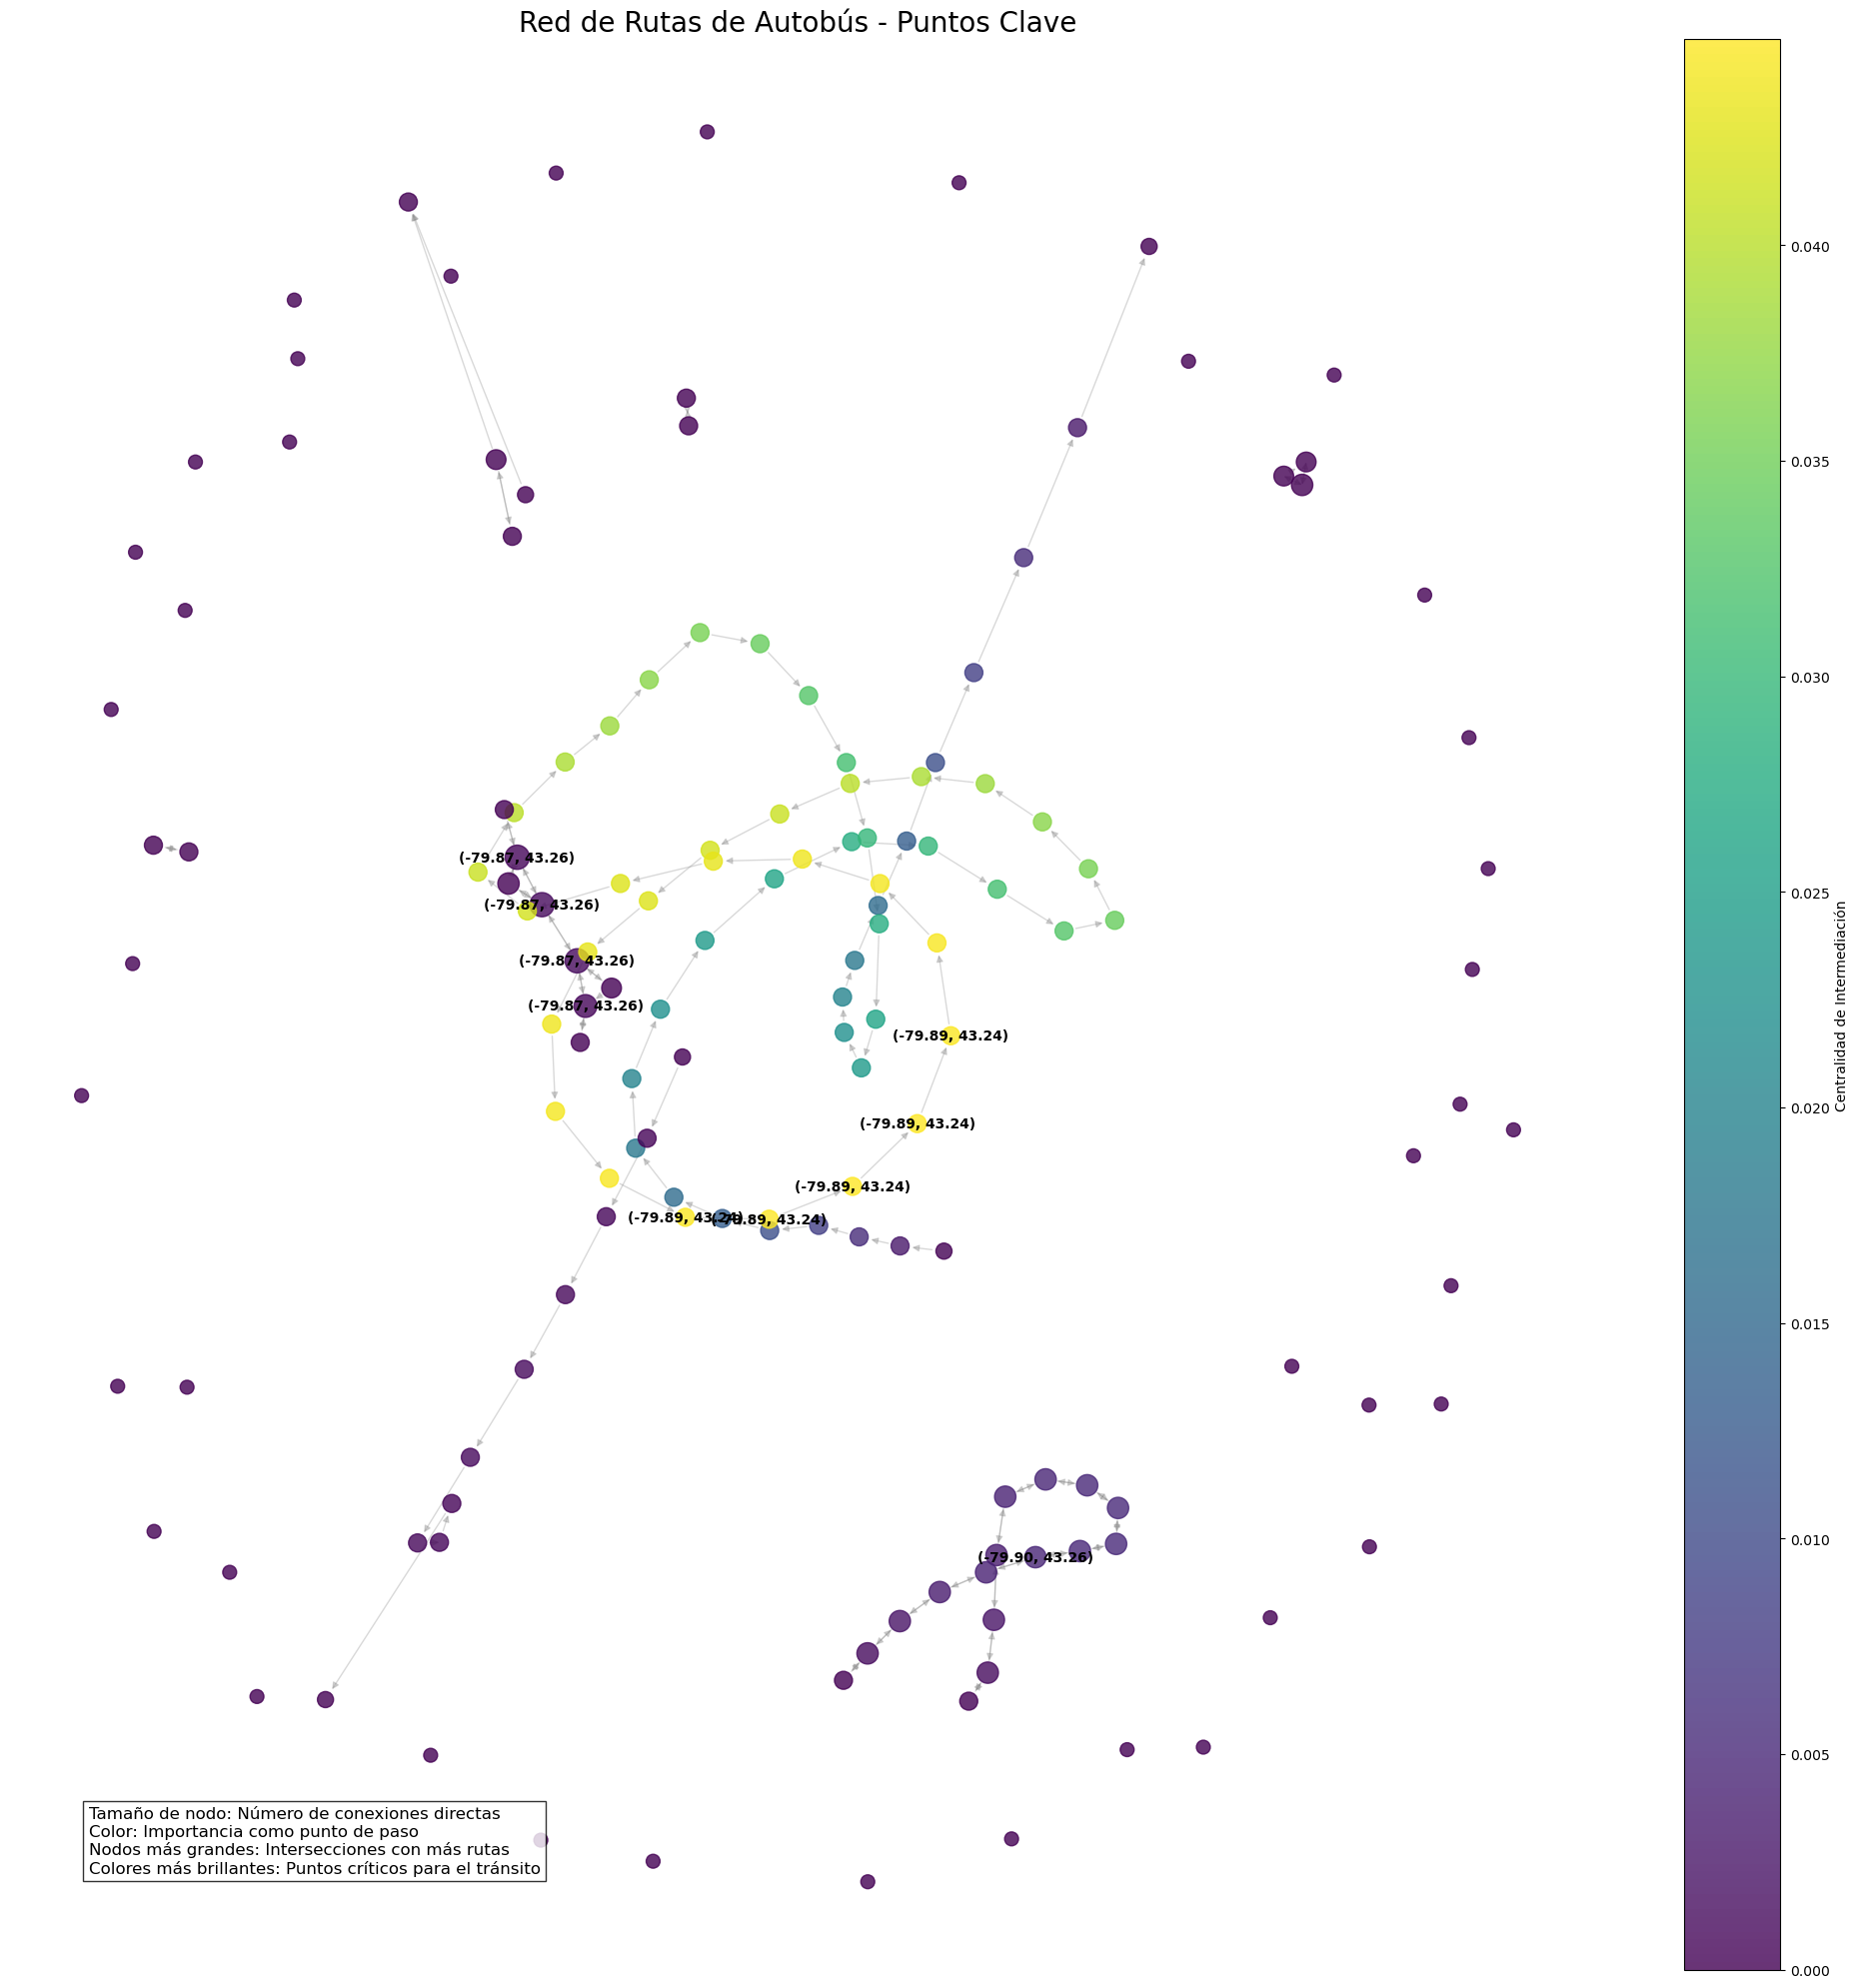


Identificando comunidades en la red de transporte...
Se han identificado 54 comunidades principales

Tamaño de cada comunidad:
Comunidad 20: 14 nodos
Comunidad 23: 12 nodos
Comunidad 34: 12 nodos
Comunidad 0: 10 nodos
Comunidad 17: 10 nodos
Comunidad 12: 8 nodos
Comunidad 18: 8 nodos
Comunidad 29: 8 nodos
Comunidad 36: 8 nodos
Comunidad 13: 7 nodos
Comunidad 25: 4 nodos
Comunidad 31: 3 nodos
Comunidad 4: 2 nodos
Comunidad 38: 2 nodos
Comunidad 2: 1 nodos
Comunidad 5: 1 nodos
Comunidad 6: 1 nodos
Comunidad 9: 1 nodos
Comunidad 10: 1 nodos
Comunidad 11: 1 nodos
Comunidad 14: 1 nodos
Comunidad 16: 1 nodos
Comunidad 19: 1 nodos
Comunidad 21: 1 nodos
Comunidad 22: 1 nodos
Comunidad 24: 1 nodos
Comunidad 26: 1 nodos
Comunidad 27: 1 nodos
Comunidad 28: 1 nodos
Comunidad 30: 1 nodos
Comunidad 32: 1 nodos
Comunidad 33: 1 nodos
Comunidad 35: 1 nodos
Comunidad 37: 1 nodos
Comunidad 39: 1 nodos
Comunidad 40: 1 nodos
Comunidad 41: 1 nodos
Comunidad 42: 1 nodos
Comunidad 43: 1 nodos
Comunidad 44: 1

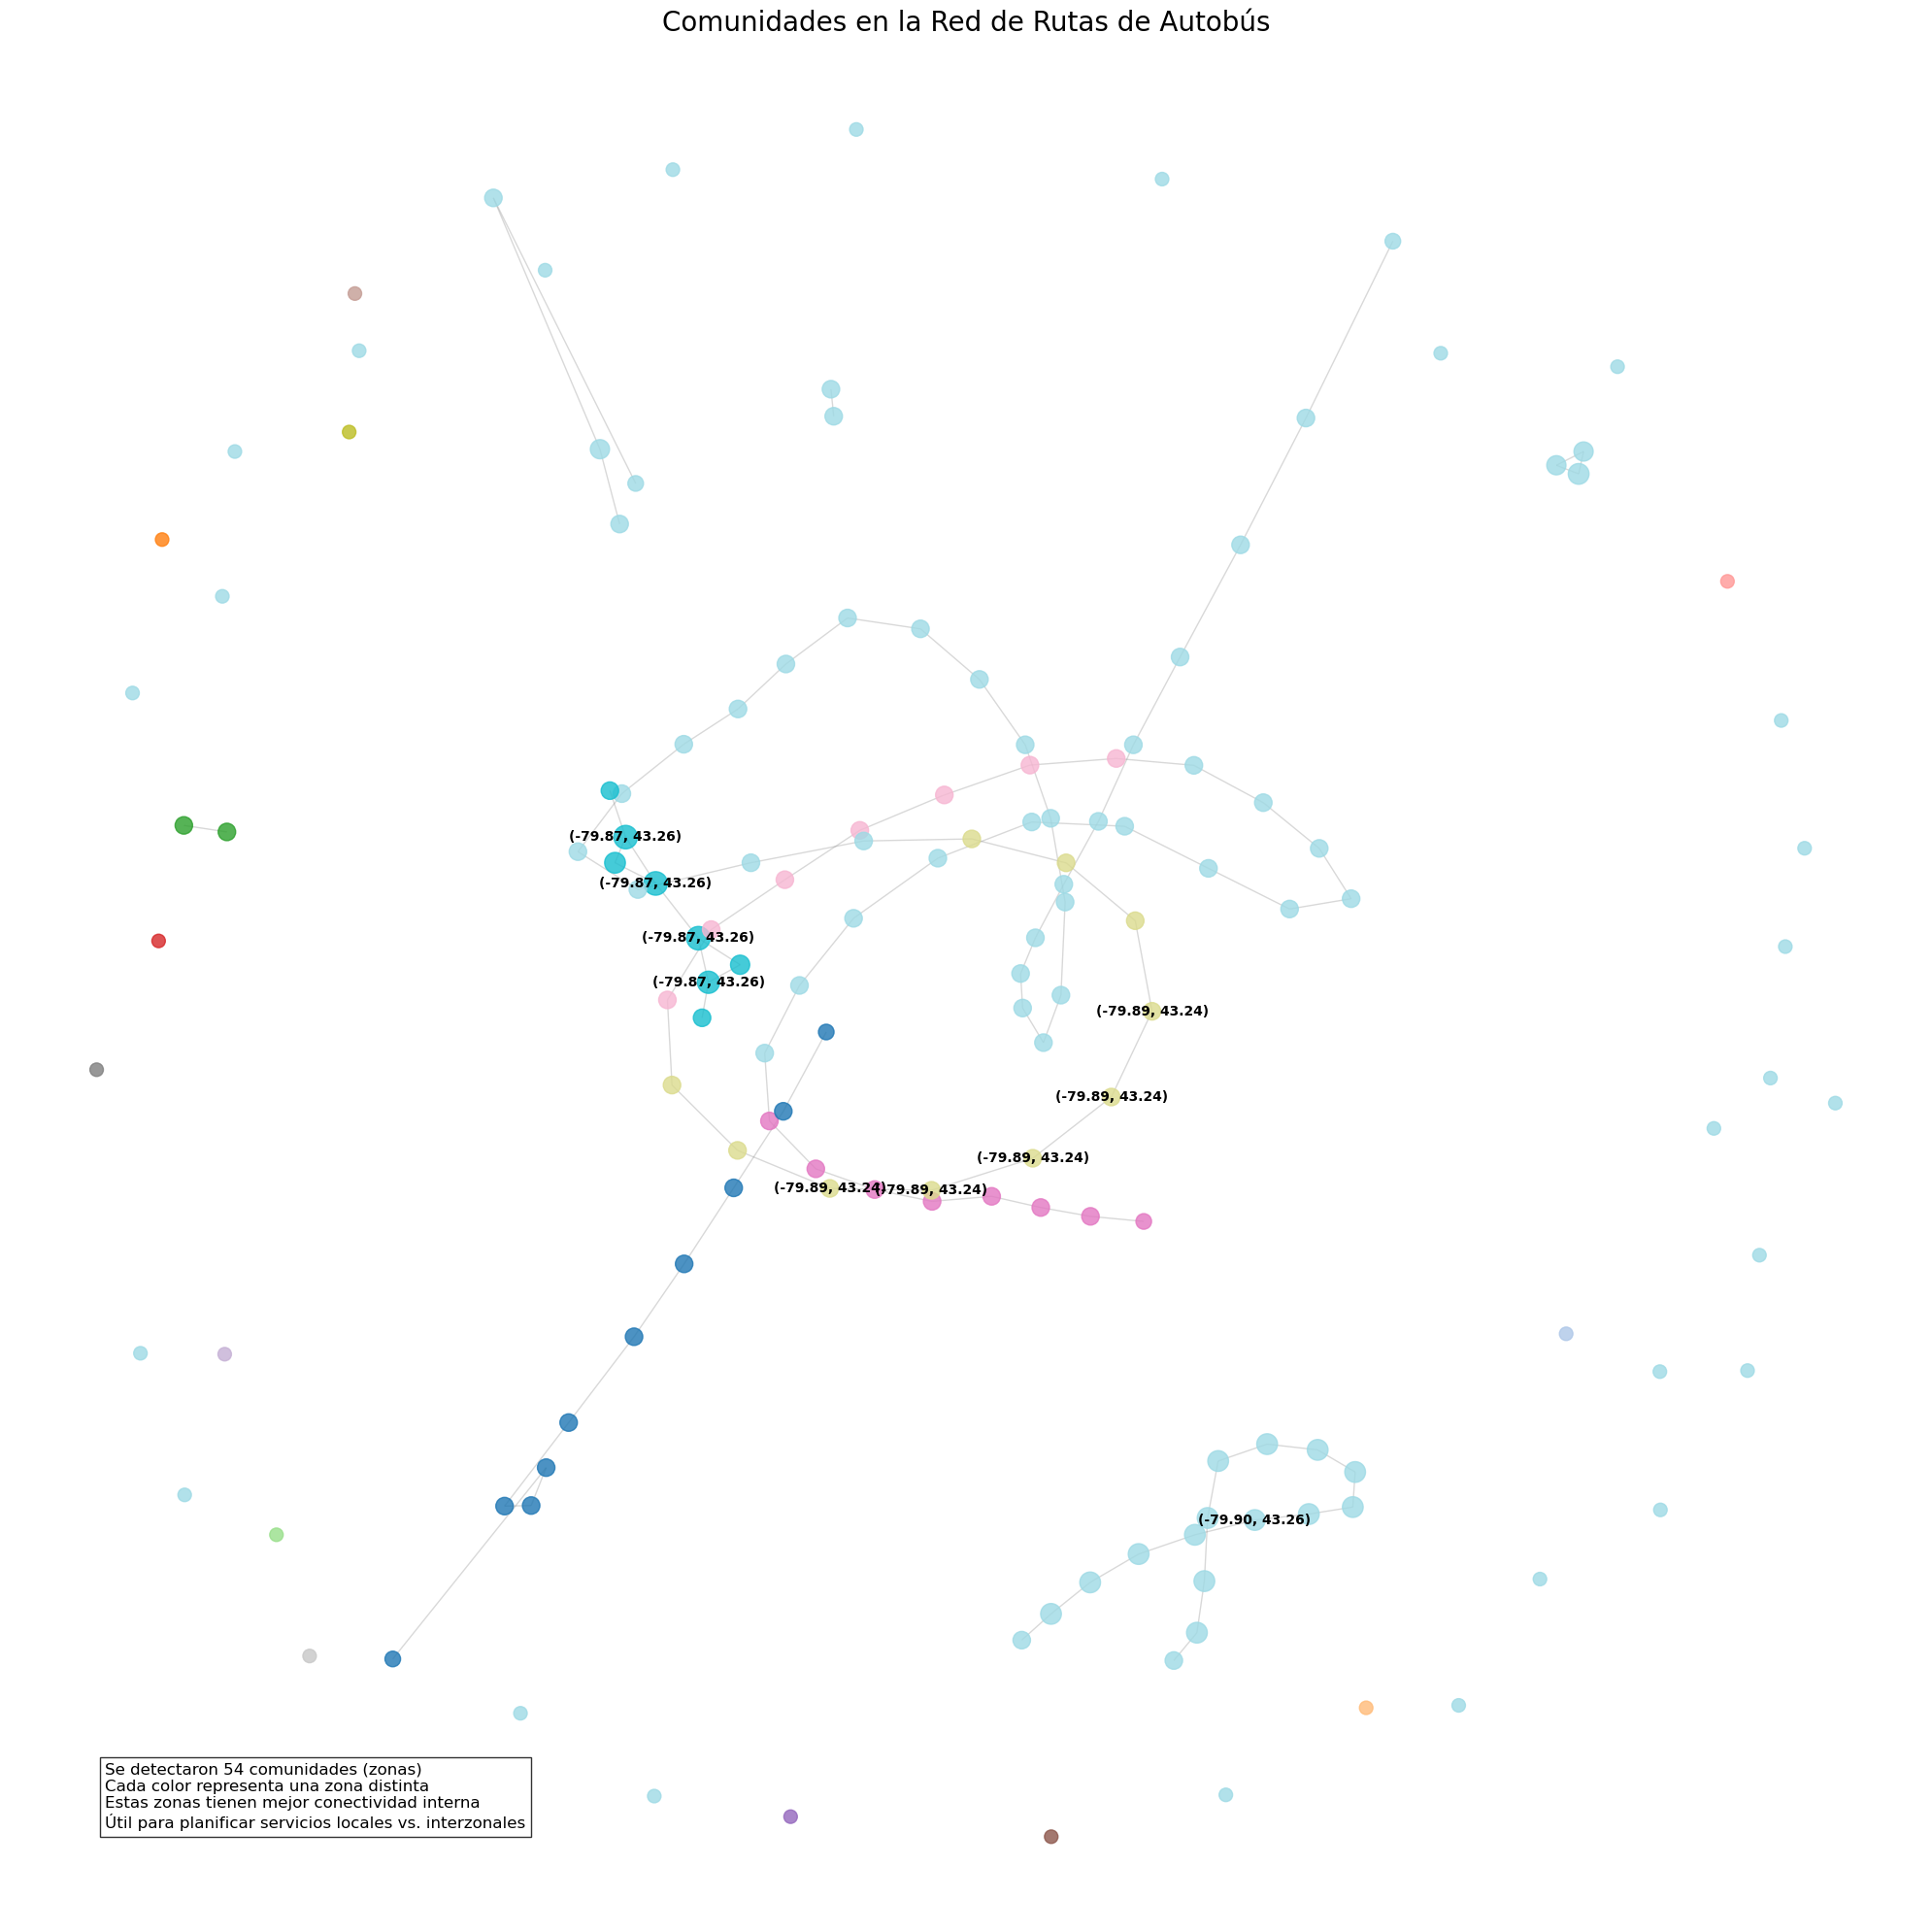


Creando mapa interactivo con los puntos clave...

Análisis completado. Se han generado archivos:
network_analysis_bus_routes.png - Gráfico de la red
network_communities_bus_routes.png - Análisis de comunidades
bus_network_analysis_map.html - Mapa interactivo con puntos clave

Conclusiones del análisis:
Los puntos con mayor centralidad de grado son intersecciones donde convergen múltiples rutas
Los puntos con mayor intermediación son críticos para mantener la conectividad de la red
Las comunidades detectadas representan zonas con buena conectividad interna


In [26]:
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import folium

# Paso 1: Cargar los datos GeoJSON y explorarlos
print("Cargando datos de rutas de autobús...")
data = gpd.read_file("bus_routes.geojson")
print(f"Número de rutas cargadas: {len(data)}")
print("\nPrimeras líneas de datos:")
print(data.head())
print("\nColumnas disponibles:")
print(data.columns.tolist())

# Paso 2: Crear una red (grafo) a partir de los datos geoespaciales
print("\nCreando red de transporte a partir de las rutas...")
G = nx.DiGraph()  # Grafo dirigido

# La función para añadir los segmentos de ruta al grafo
def add_route_segments_to_graph(G, route_data):
    count = 0
    for _, row in route_data.iterrows():
        route_id = row['LINE_NUMBER'] if 'LINE_NUMBER' in row else 'Unknown'
        
        # Manejar tanto MultiLineString como LineString
        if row['geometry'].geom_type == 'MultiLineString':
            for line in row['geometry'].geoms:
                coords = list(line.coords)
                for i in range(len(coords) - 1):
                    G.add_edge(coords[i], coords[i + 1], 
                              route_id=route_id, 
                              distance=line.length)
                    count += 1
        elif row['geometry'].geom_type == 'LineString':
            coords = list(row['geometry'].coords)
            for i in range(len(coords) - 1):
                G.add_edge(coords[i], coords[i + 1], 
                          route_id=route_id, 
                          distance=line.length)
                count += 1
    return count

# Añadir los segmentos al grafo
edge_count = add_route_segments_to_graph(G, data)
print(f"Red creada con {G.number_of_nodes()} nodos y {G.number_of_edges()} segmentos de ruta.")

# Paso 3: Análisis básico de la red
print("\nEstadísticas básicas de la red:")
print(f"Número de nodos (intersecciones): {G.number_of_nodes()}")
print(f"Número de enlaces (segmentos de ruta): {G.number_of_edges()}")
print(f"Densidad de la red: {nx.density(G):.6f}")

# Paso 4: Calcular métricas de centralidad
print("\nCalculando métricas de centralidad (esto puede tomar un momento)...")

# Para redes grandes, podemos usar aproximaciones o limitar el cálculo
if G.number_of_nodes() > 1000:
    print("Red grande detectada, usando aproximaciones para el cálculo de centralidad...")
    # Degree centrality (exacto)
    degree_cent = nx.degree_centrality(G)
    in_degree_cent = nx.in_degree_centrality(G) 
    out_degree_cent = nx.out_degree_centrality(G)
    
    # Betweenness centrality (aproximado con muestreo)
    betweenness_cent = nx.betweenness_centrality(G, k=100)  # k=100 significa muestreo de 100 nodos
    
    # Closeness centrality (aproximado)
    try:
        closeness_cent = nx.closeness_centrality(G)
    except:
        print("Cálculo de closeness centrality omitido debido al tamaño de la red")
        closeness_cent = {node: 0 for node in G.nodes()}  # Valores dummy
else:
    # Para redes pequeñas, calculamos todo exactamente
    degree_cent = nx.degree_centrality(G)
    in_degree_cent = nx.in_degree_centrality(G)
    out_degree_cent = nx.out_degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    closeness_cent = nx.closeness_centrality(G)

# Paso 5: Identificar los nodos más importantes
print("\n--- NODOS CON MAYOR CENTRALIDAD ---")

# Top nodos por grado
top_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nIntersecciones con más conexiones (Centralidad de Grado):")
for i, (node, value) in enumerate(top_degree):
    print(f"{i+1}. Coordenadas: ({node[0]:.4f}, {node[1]:.4f}) - Valor: {value:.4f}")

# Top nodos por intermediación
top_betweenness = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nPuntos críticos para el flujo de la red (Centralidad de Intermediación):")
for i, (node, value) in enumerate(top_betweenness):
    print(f"{i+1}. Coordenadas: ({node[0]:.4f}, {node[1]:.4f}) - Valor: {value:.4f}")

# Paso 6: Crear un subgrafo para visualización
print("\nCreando visualización de la red...")

def create_subgraph_for_visualization(G, max_nodes=200):
    """Crea un subgrafo para visualización basado en los nodos más importantes"""
    # Combinamos nodos con alta centralidad de grado e intermediación
    important_nodes = set()
    
    # Añadir nodos con alto grado
    for node, _ in sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:max_nodes//2]:
        important_nodes.add(node)
        
    # Añadir nodos con alta intermediación
    for node, _ in sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:max_nodes//2]:
        important_nodes.add(node)
    
    # Crear subgrafo
    subgraph = G.subgraph(list(important_nodes)[:max_nodes])
    return subgraph

# Crear un subgrafo manejable
sub_G = create_subgraph_for_visualization(G, max_nodes=150)

# Recalcular centralidades para el subgrafo
sub_degree_cent = nx.degree_centrality(sub_G)
sub_betweenness_cent = nx.betweenness_centrality(sub_G)

# Paso 7: Visualizar la red
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(sub_G, seed=42)

# Tamaño basado en degree, color basado en betweenness
node_sizes = [sub_degree_cent[node] * 5000 + 100 for node in sub_G.nodes()]
node_colors = [sub_betweenness_cent[node] for node in sub_G.nodes()]

# Dibujar enlaces y nodos
nx.draw_networkx_edges(sub_G, pos, alpha=0.3, edge_color="gray")
nodes = nx.draw_networkx_nodes(sub_G, pos, 
                             node_size=node_sizes,
                             node_color=node_colors, 
                             cmap=plt.cm.viridis,
                             alpha=0.8)

# Barra de color para betweenness
plt.colorbar(nodes, label="Centralidad de Intermediación")

# Etiquetar solo los nodos más importantes
top_nodes = set()
for node, _ in sorted(sub_degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    top_nodes.add(node)
for node, _ in sorted(sub_betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    top_nodes.add(node)

node_labels = {node: f"({node[0]:.2f}, {node[1]:.2f})" for node in top_nodes}
nx.draw_networkx_labels(sub_G, pos, labels=node_labels, font_size=10, font_weight="bold")

# Título y leyenda
plt.title("Red de Rutas de Autobús - Puntos Clave", fontsize=20)
plt.text(0.05, 0.05, 
         "Tamaño de nodo: Número de conexiones directas\n"
         "Color: Importancia como punto de paso\n" 
         "Nodos más grandes: Intersecciones con más rutas\n"
         "Colores más brillantes: Puntos críticos para el tránsito", 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=12)

plt.axis("off")
plt.tight_layout()
plt.savefig('network_analysis_bus_routes.png', dpi=300, bbox_inches='tight')
plt.show()

# Paso 8: Análisis de comunidades (si es posible)
try:
    # Convertir a grafo no dirigido para detección de comunidades
    print("\nIdentificando comunidades en la red de transporte...")
    G_undirected = sub_G.to_undirected()
    
    import community
    partition = community.best_partition(G_undirected)
    communities = set(partition.values())
    print(f"Se han identificado {len(communities)} comunidades principales")
    
    # Contar nodos por comunidad
    community_counts = {}
    for node, comm in partition.items():
        if comm in community_counts:
            community_counts[comm] += 1
        else:
            community_counts[comm] = 1
    
    print("\nTamaño de cada comunidad:")
    for comm_id, count in sorted(community_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"Comunidad {comm_id}: {count} nodos")
    
    # Visualizar comunidades
    plt.figure(figsize=(20, 20))
    
    # Color por comunidad
    cmap = plt.get_cmap('tab20')
    node_colors = [cmap(partition[node]) for node in G_undirected.nodes()]
    
    nx.draw_networkx_edges(G_undirected, pos, alpha=0.3, edge_color="gray")
    nx.draw_networkx_nodes(G_undirected, pos, 
                          node_size=node_sizes,
                          node_color=node_colors, 
                          alpha=0.8)
    
    # Etiquetar nodos importantes
    nx.draw_networkx_labels(G_undirected, pos, labels=node_labels, font_size=10, font_weight="bold")
    
    plt.title("Comunidades en la Red de Rutas de Autobús", fontsize=20)
    plt.text(0.05, 0.05, 
             f"Se detectaron {len(communities)} comunidades (zonas)\n"
             "Cada color representa una zona distinta\n"
             "Estas zonas tienen mejor conectividad interna\n"
             "Útil para planificar servicios locales vs. interzonales", 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=12)
    
    plt.axis("off")
    plt.tight_layout()
    plt.savefig('network_communities_bus_routes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except Exception as e:
    print(f"No se pudo realizar el análisis de comunidades: {e}")
    print("Intente instalar la biblioteca 'python-louvain' con: pip install python-louvain")

# Paso 9: Visualización interactiva con folium
print("\nCreando mapa interactivo con los puntos clave...")

# Crear un mapa centrado
center_lat = np.mean([node[1] for node in G.nodes()])
center_lon = np.mean([node[0] for node in G.nodes()])
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Añadir las rutas de autobús como base
folium.GeoJson(data, name='Rutas de Autobús', 
              style_function=lambda x: {'color': 'gray', 'weight': 2, 'opacity': 0.7}).add_to(m)

# Añadir los puntos más importantes
fg_degree = folium.FeatureGroup(name='Puntos con más conexiones')
fg_betweenness = folium.FeatureGroup(name='Puntos críticos para el flujo')

# Nodos con alto grado de centralidad
for node, value in top_degree:
    folium.CircleMarker(
        location=[node[1], node[0]],  # Convertir lon,lat a lat,lon
        radius=10,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        tooltip=f"Centralidad de grado: {value:.4f}"
    ).add_to(fg_degree)

# Nodos con alta intermediación
for node, value in top_betweenness:
    folium.CircleMarker(
        location=[node[1], node[0]],  # Convertir lon,lat a lat,lon
        radius=10,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        tooltip=f"Centralidad de intermediación: {value:.4f}"
    ).add_to(fg_betweenness)

# Añadir capas al mapa
fg_degree.add_to(m)
fg_betweenness.add_to(m)

# Añadir control de capas
folium.LayerControl().add_to(m)

# Guardar el mapa
m.save("bus_network_analysis_map.html")

print("\nAnálisis completado. Se han generado archivos:")
print("network_analysis_bus_routes.png - Gráfico de la red")
print("network_communities_bus_routes.png - Análisis de comunidades")
print("bus_network_analysis_map.html - Mapa interactivo con puntos clave")

print("\nConclusiones del análisis:")
print("Los puntos con mayor centralidad de grado son intersecciones donde convergen múltiples rutas")
print("Los puntos con mayor intermediación son críticos para mantener la conectividad de la red")
print("Las comunidades detectadas representan zonas con buena conectividad interna")
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import folium

# Paso 1: Cargar los datos GeoJSON y explorarlos
print("Cargando datos de rutas de autobús...")
data = gpd.read_file("bus_routes.geojson")
print(f"Número de rutas cargadas: {len(data)}")
print("\nPrimeras líneas de datos:")
print(data.head())
print("\nColumnas disponibles:")
print(data.columns.tolist())

# Paso 2: Crear una red (grafo) a partir de los datos geoespaciales
print("\nCreando red de transporte a partir de las rutas...")
G = nx.DiGraph()  # Grafo dirigido

# La función para añadir los segmentos de ruta al grafo
def add_route_segments_to_graph(G, route_data):
    count = 0
    for _, row in route_data.iterrows():
        route_id = row['LINE_NUMBER'] if 'LINE_NUMBER' in row else 'Unknown'
        
        # Manejar tanto MultiLineString como LineString
        if row['geometry'].geom_type == 'MultiLineString':
            for line in row['geometry'].geoms:
                coords = list(line.coords)
                for i in range(len(coords) - 1):
                    G.add_edge(coords[i], coords[i + 1], 
                              route_id=route_id, 
                              distance=line.length)
                    count += 1
        elif row['geometry'].geom_type == 'LineString':
            coords = list(row['geometry'].coords)
            for i in range(len(coords) - 1):
                G.add_edge(coords[i], coords[i + 1], 
                          route_id=route_id, 
                          distance=line.length)
                count += 1
    return count

# Añadir los segmentos al grafo
edge_count = add_route_segments_to_graph(G, data)
print(f"Red creada con {G.number_of_nodes()} nodos y {G.number_of_edges()} segmentos de ruta.")

# Paso 3: Análisis básico de la red
print("\nEstadísticas básicas de la red:")
print(f"Número de nodos (intersecciones): {G.number_of_nodes()}")
print(f"Número de enlaces (segmentos de ruta): {G.number_of_edges()}")
print(f"Densidad de la red: {nx.density(G):.6f}")

# Paso 4: Calcular métricas de centralidad
print("\nCalculando métricas de centralidad (esto puede tomar un momento)...")

# Para redes grandes, podemos usar aproximaciones o limitar el cálculo
if G.number_of_nodes() > 1000:
    print("Red grande detectada, usando aproximaciones para el cálculo de centralidad...")
    # Degree centrality (exacto)
    degree_cent = nx.degree_centrality(G)
    in_degree_cent = nx.in_degree_centrality(G) 
    out_degree_cent = nx.out_degree_centrality(G)
    
    # Betweenness centrality (aproximado con muestreo)
    betweenness_cent = nx.betweenness_centrality(G, k=100)  # k=100 significa muestreo de 100 nodos
    
    # Closeness centrality (aproximado)
    try:
        closeness_cent = nx.closeness_centrality(G)
    except:
        print("Cálculo de closeness centrality omitido debido al tamaño de la red")
        closeness_cent = {node: 0 for node in G.nodes()}  # Valores dummy
else:
    # Para redes pequeñas, calculamos todo exactamente
    degree_cent = nx.degree_centrality(G)
    in_degree_cent = nx.in_degree_centrality(G)
    out_degree_cent = nx.out_degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    closeness_cent = nx.closeness_centrality(G)

# Paso 5: Identificar los nodos más importantes
print("\n--- NODOS CON MAYOR CENTRALIDAD ---")

# Top nodos por grado
top_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nIntersecciones con más conexiones (Centralidad de Grado):")
for i, (node, value) in enumerate(top_degree):
    print(f"{i+1}. Coordenadas: ({node[0]:.4f}, {node[1]:.4f}) - Valor: {value:.4f}")

# Top nodos por intermediación
top_betweenness = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nPuntos críticos para el flujo de la red (Centralidad de Intermediación):")
for i, (node, value) in enumerate(top_betweenness):
    print(f"{i+1}. Coordenadas: ({node[0]:.4f}, {node[1]:.4f}) - Valor: {value:.4f}")

# Paso 6: Crear un subgrafo para visualización
print("\nCreando visualización de la red...")

def create_subgraph_for_visualization(G, max_nodes=200):
    """Crea un subgrafo para visualización basado en los nodos más importantes"""
    # Combinamos nodos con alta centralidad de grado e intermediación
    important_nodes = set()
    
    # Añadir nodos con alto grado
    for node, _ in sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:max_nodes//2]:
        important_nodes.add(node)
        
    # Añadir nodos con alta intermediación
    for node, _ in sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:max_nodes//2]:
        important_nodes.add(node)
    
    # Crear subgrafo
    subgraph = G.subgraph(list(important_nodes)[:max_nodes])
    return subgraph

# Crear un subgrafo manejable
sub_G = create_subgraph_for_visualization(G, max_nodes=150)

# Recalcular centralidades para el subgrafo
sub_degree_cent = nx.degree_centrality(sub_G)
sub_betweenness_cent = nx.betweenness_centrality(sub_G)

# Paso 7: Visualizar la red
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(sub_G, seed=42)

# Tamaño basado en degree, color basado en betweenness
node_sizes = [sub_degree_cent[node] * 5000 + 100 for node in sub_G.nodes()]
node_colors = [sub_betweenness_cent[node] for node in sub_G.nodes()]

# Dibujar enlaces y nodos
nx.draw_networkx_edges(sub_G, pos, alpha=0.3, edge_color="gray")
nodes = nx.draw_networkx_nodes(sub_G, pos, 
                             node_size=node_sizes,
                             node_color=node_colors, 
                             cmap=plt.cm.viridis,
                             alpha=0.8)

# Barra de color para betweenness
plt.colorbar(nodes, label="Centralidad de Intermediación")

# Etiquetar solo los nodos más importantes
top_nodes = set()
for node, _ in sorted(sub_degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    top_nodes.add(node)
for node, _ in sorted(sub_betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    top_nodes.add(node)

node_labels = {node: f"({node[0]:.2f}, {node[1]:.2f})" for node in top_nodes}
nx.draw_networkx_labels(sub_G, pos, labels=node_labels, font_size=10, font_weight="bold")

# Título y leyenda
plt.title("Red de Rutas de Autobús - Puntos Clave", fontsize=20)
plt.text(0.05, 0.05, 
         "Tamaño de nodo: Número de conexiones directas\n"
         "Color: Importancia como punto de paso\n" 
         "Nodos más grandes: Intersecciones con más rutas\n"
         "Colores más brillantes: Puntos críticos para el tránsito", 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=12)

plt.axis("off")
plt.tight_layout()
plt.savefig('network_analysis_bus_routes.png', dpi=300, bbox_inches='tight')
plt.show()

# Paso 8: Análisis de comunidades (si es posible)
try:
    # Convertir a grafo no dirigido para detección de comunidades
    print("\nIdentificando comunidades en la red de transporte...")
    G_undirected = sub_G.to_undirected()
    
    import community
    partition = community.best_partition(G_undirected)
    communities = set(partition.values())
    print(f"Se han identificado {len(communities)} comunidades principales")
    
    # Contar nodos por comunidad
    community_counts = {}
    for node, comm in partition.items():
        if comm in community_counts:
            community_counts[comm] += 1
        else:
            community_counts[comm] = 1
    
    print("\nTamaño de cada comunidad:")
    for comm_id, count in sorted(community_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"Comunidad {comm_id}: {count} nodos")
    
    # Visualizar comunidades
    plt.figure(figsize=(20, 20))
    
    # Color por comunidad
    cmap = plt.get_cmap('tab20')
    node_colors = [cmap(partition[node]) for node in G_undirected.nodes()]
    
    nx.draw_networkx_edges(G_undirected, pos, alpha=0.3, edge_color="gray")
    nx.draw_networkx_nodes(G_undirected, pos, 
                          node_size=node_sizes,
                          node_color=node_colors, 
                          alpha=0.8)
    
    # Etiquetar nodos importantes
    nx.draw_networkx_labels(G_undirected, pos, labels=node_labels, font_size=10, font_weight="bold")
    
    plt.title("Comunidades en la Red de Rutas de Autobús", fontsize=20)
    plt.text(0.05, 0.05, 
             f"Se detectaron {len(communities)} comunidades (zonas)\n"
             "Cada color representa una zona distinta\n"
             "Estas zonas tienen mejor conectividad interna\n"
             "Útil para planificar servicios locales vs. interzonales", 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=12)
    
    plt.axis("off")
    plt.tight_layout()
    plt.savefig('network_communities_bus_routes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except Exception as e:
    print(f"No se pudo realizar el análisis de comunidades: {e}")
    print("Intente instalar la biblioteca 'python-louvain' con: pip install python-louvain")

# Paso 9: Visualización interactiva con folium
print("\nCreando mapa interactivo con los puntos clave...")

# Crear un mapa centrado
center_lat = np.mean([node[1] for node in G.nodes()])
center_lon = np.mean([node[0] for node in G.nodes()])
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Añadir las rutas de autobús como base
folium.GeoJson(data, name='Rutas de Autobús', 
              style_function=lambda x: {'color': 'gray', 'weight': 2, 'opacity': 0.7}).add_to(m)

# Añadir los puntos más importantes
fg_degree = folium.FeatureGroup(name='Puntos con más conexiones')
fg_betweenness = folium.FeatureGroup(name='Puntos críticos para el flujo')

# Nodos con alto grado de centralidad
for node, value in top_degree:
    folium.CircleMarker(
        location=[node[1], node[0]],  # Convertir lon,lat a lat,lon
        radius=10,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        tooltip=f"Centralidad de grado: {value:.4f}"
    ).add_to(fg_degree)

# Nodos con alta intermediación
for node, value in top_betweenness:
    folium.CircleMarker(
        location=[node[1], node[0]],  # Convertir lon,lat a lat,lon
        radius=10,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        tooltip=f"Centralidad de intermediación: {value:.4f}"
    ).add_to(fg_betweenness)

# Añadir capas al mapa
fg_degree.add_to(m)
fg_betweenness.add_to(m)

# Añadir control de capas
folium.LayerControl().add_to(m)

# Guardar el mapa
m.save("bus_network_analysis_map.html")

print("\nAnálisis completado. Se han generado archivos:")
print("network_analysis_bus_routes.png - Gráfico de la red")
print("network_communities_bus_routes.png - Análisis de comunidades")
print("bus_network_analysis_map.html - Mapa interactivo con puntos clave")

print("\nConclusiones del análisis:")
print("Los puntos con mayor centralidad de grado son intersecciones donde convergen múltiples rutas")
print("Los puntos con mayor intermediación son críticos para mantener la conectividad de la red")
print("Las comunidades detectadas representan zonas con buena conectividad interna")